In [267]:
## Only for colab
# from google.colab import drive
# drive.mount('/content/gdrive')

# %cd /content/gdrive/MyDrive/DOPP_Group_2/FinalSubmission_Group2/

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/DOPP_Group_2/FinalSubmission_Group2


In [268]:
# Imports
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import glob
from pathlib import Path
import xlrd

from plotly.subplots import make_subplots
import plotly.graph_objs as go

import scipy as sp
from scipy.stats import boxcox

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn import decomposition

import plotly.graph_objs as go 
import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.express as px
from matplotlib.collections import EllipseCollection



import warnings
warnings.filterwarnings("ignore")

# Load Transparency International Dataset

## The CPI - Corruption Perception Index

The probably most known index for evaluating the level of corruption in a country is the Corruption Perception Index (CPI). It is calculated every year by Tranparency International, an organization aiming to stop corruption and promote transparency. The index ranks 180 countries around the world by their perceived levels of public sector corruption according to experts and businesspeople. It uses a scale from 0 to 100, where 0 is highly corrupt and 100 is very clean. Because this Index considers numerous factors, is renowned worldwide and has an extensive and transparent data set, we chose it as our primary source for measuring a country’s degree of corruption.
Source: https://www.transparency.org/en/cpi/2020/index/nzl

## Load the CSV Data

In [269]:
# list of our original data files
# we'll deal with the CSVs first
glob.glob("Datasets/Transparency International/Original Data/*")

['Datasets/Transparency International/Original Data/CPI-Archive-2008-2.csv',
 'Datasets/Transparency International/Original Data/CPI-2007-new_200602_092501.csv',
 'Datasets/Transparency International/Original Data/CPI-2005_200602_104136.csv',
 'Datasets/Transparency International/Original Data/CPI-2011-new_200601_104308.csv',
 'Datasets/Transparency International/Original Data/CPI-2009-new_200601_120052.csv',
 'Datasets/Transparency International/Original Data/CPI-2006-new_200602_095933.csv',
 'Datasets/Transparency International/Original Data/CPI-2010-new_200601_105629.csv',
 'Datasets/Transparency International/Original Data/CPI2020_GlobalTablesTS_210125.xlsx',
 'Datasets/Transparency International/Original Data/CPI-2004_200602_110140.csv',
 'Datasets/Transparency International/Original Data/CPI-2003_200602_113929.csv',
 'Datasets/Transparency International/Original Data/CPI-2002_200602_115328.csv',
 'Datasets/Transparency International/Original Data/CPI-2001_200603_082938.csv',
 'Da

In [270]:
# check one csv file to see the header situation
data_path = 'Datasets/Transparency International/Original Data/'
filename = 'CPI-2000_200603_083012.csv'

df = pd.read_csv(data_path+filename)

print(df.columns)
df.head()

Index(['country', 'iso', 'region', 'score', 'rank', 'interval'], dtype='object')


,country,iso,region,score,rank,interval
0,Angola,AGO,SSA,1.7,85,1.6 - 2.5
1,Argentina,ARG,AME,3.5,52,3.0 - 4.5
2,Armenia,ARM,ECA,2.5,76,2.4 - 3.5
3,Australia,AUS,AP,8.3,13,6.7 - 9.3
4,Austria,AUT,WE/EU,7.7,15,6.2 - 8.5


In [271]:
# Check number of columns and rows for each file
files = glob.glob("Datasets/Transparency International/Original Data/*.csv")

countries = pd.DataFrame() # dataframe of country and iso
shape_list = {}
for filename in files:
    df = pd.read_csv(filename, index_col=None, header=0, low_memory=False)
    shape_list[filename[50:]] = df.shape
    countries = countries.append(df[['iso', 'country']],  ignore_index=True)  
shape_list

# we see that not every file has the same number of rows (countries)
# inconsistent number of countries needs to be investigated

{'CPI-2000_200603_083012.csv': (90, 6),
 'CPI-2001_200603_082938.csv': (91, 6),
 'CPI-2002_200602_115328.csv': (102, 6),
 'CPI-2003_200602_113929.csv': (133, 6),
 'CPI-2004_200602_110140.csv': (146, 6),
 'CPI-2005_200602_104136.csv': (159, 6),
 'CPI-2006-new_200602_095933.csv': (163, 6),
 'CPI-2007-new_200602_092501.csv': (180, 6),
 'CPI-2009-new_200601_120052.csv': (180, 6),
 'CPI-2010-new_200601_105629.csv': (178, 6),
 'CPI-2011-new_200601_104308.csv': (183, 6),
 'CPI-Archive-2008-2.csv': (180, 6)}

In [272]:
# check country and iso combinations
countries = countries.sort_values(by=['iso'])
countries.groupby(['iso','country']).size()

# we see a lot of inconsistent naming and iso:

# COD  Congo Democratic Republic            1
#      Congo, Democratic Republic           3
#      Congo. Democratic Republic           1
#      Democratic Republic of Congo         1
#      Democratic Republic of the Congo     2
# COG  Congo                                1
#      Congo Republic                       2
#      Congo, Republic                      2
#      Congo, Republic of                   1
#      Congo, Republic of the               1
#      Congo-Brazzaville                    1
#      Congo. Republic of                   1

iso  country             
AFG  Afghanistan              6
AGO  Angola                  11
ALB  Albania                 10
ARE  United Arab Emirates     9
ARG  Argentina               12
                             ..
YEM  Yemen                    9
YUG  Yugoslavia               1
ZAF  South Africa            12
ZMB  Zambia                  12
ZWE  Zimbabwe                12
Length: 243, dtype: int64

In [273]:
# Combine files into a data frame
source_files = sorted(Path('Datasets/Transparency International/Original Data').glob('*.csv'))

dataframes = []
for file in source_files:
    df = pd.read_csv(file) 
    df['Source'] = file.name
    dataframes.append(df)

df_csv = pd.concat(dataframes)

# we can drop 'interval', this column is missing in the XLSX 
df_csv.drop('interval', axis=1, inplace=True)

# rename columns to later match the XLSX file
df_csv.rename(columns = {'country':'Country', 'iso':'ISO', 'region':'Region', 'score':'Score', 'rank':'Rank', 'range':'Year'}, inplace = True)

# get year from the file names
df_csv['Year'] = df_csv.Source.str[4:8]
df_csv['Year'].replace({'Arch':'2008'}, inplace = True)

# move 'Year' to front
col = df_csv.pop("Year")
df_csv.insert(0, col.name, col)

df_csv.head(n=10)

,Year,Country,ISO,Region,Score,Rank,Source
0,2000,Angola,AGO,SSA,1.7,85,CPI-2000_200603_083012.csv
1,2000,Argentina,ARG,AME,3.5,52,CPI-2000_200603_083012.csv
2,2000,Armenia,ARM,ECA,2.5,76,CPI-2000_200603_083012.csv
3,2000,Australia,AUS,AP,8.3,13,CPI-2000_200603_083012.csv
4,2000,Austria,AUT,WE/EU,7.7,15,CPI-2000_200603_083012.csv
5,2000,Azerbaijan,AZE,ECA,1.5,87,CPI-2000_200603_083012.csv
6,2000,Belarus,BLR,ECA,4.1,43,CPI-2000_200603_083012.csv
7,2000,Belgium,BEL,WE/EU,6.1,25,CPI-2000_200603_083012.csv
8,2000,Bolivia,BOL,AME,2.7,71,CPI-2000_200603_083012.csv
9,2000,Botswana,BWA,SSA,6,26,CPI-2000_200603_083012.csv


In [274]:
# Replace commas with periods

# we see some values with commas instead of periods (3,7 and 3,8)

# 2005	Brazil	            BRA	AME	3,7	62.0	CPI-2005_200602_104136.csv
# 2005	Thailand    	      THA	AP	3,8	59.0	CPI-2005_200602_104136.csv
# 2005	Trinidad and Tobago	TTO	AME	3,8	59.0	CPI-2005_200602_104136.csv

#replace comma with period
df_csv['Score'] = df_csv['Score'].astype(str)

df_csv['Score'] = df_csv['Score'].str.strip()

df_csv['Score'] = df_csv['Score'].str.replace('3,7','3.7')
df_csv['Score'] = df_csv['Score'].str.replace('3,8','3.8')
df_csv['Score'] = df_csv['Score'].astype(float)
df_csv['Score'].unique()

array([ 1.7,  3.5,  2.5,  8.3,  7.7,  1.5,  4.1,  6.1,  2.7,  6. ,  3.9,
        3. ,  2. ,  9.2,  7.4,  3.1,  3.2,  5.4,  3.7,  4.3,  9.8,  2.6,
        5.7, 10. ,  6.7,  7.6,  4.9,  5.2,  9.1,  2.8,  7.2,  6.6,  4.6,
        6.4,  2.1,  3.4,  8.6,  4.8,  4.7,  3.3,  2.2,  8.9,  9.4,  1.2,
        4.4,  2.9,  5.5,  5. ,  4. ,  7. ,  3.8,  2.3,  8.7,  7.8,  2.4,
        1.3,  8.5,  0.4,  7.5,  4.5,  9.5,  3.6,  5.6,  9.9,  4.2,  7.9,
        5.3,  1.9,  7.1,  8.8,  1. ,  6.3,  9. ,  8.4,  5.9,  5.1,  9.7,
        7.3,  8.2,  6.9,  1.6,  9.3,  1.8,  8. ,  9.6,  1.4,  5.8,  6.8,
        6.2,  6.5,  8.1,  1.1])

In [275]:
# multiply Score by 10
# from 2012 they range from 0 (highly corrupt) to 100 (not corrupt)
df_csv['Score'] = df_csv['Score'].multiply(10)
df_csv['Score'] = df_csv['Score'].astype(int)

df_csv['Score'].unique()

array([ 17,  35,  25,  83,  77,  15,  41,  61,  27,  60,  39,  30,  20,
        92,  74,  31,  32,  54,  37,  43,  98,  26,  57, 100,  67,  76,
        49,  52,  91,  28,  72,  66,  46,  64,  21,  34,  86,  48,  47,
        33,  22,  89,  94,  12,  44,  29,  55,  50,  40,  70,  38,  23,
        87,  78,  24,  13,  85,   4,  75,  45,  95,  36,  56,  99,  42,
        79,  53,  19,  71,  88,  10,  63,  90,  84,  59,  51,  97,  73,
        82,  69,  16,  93,  18,  80,  96,  14,  58,  68,  62,  65,  81,
        11])

In [276]:
df_csv.head()

,Year,Country,ISO,Region,Score,Rank,Source
0,2000,Angola,AGO,SSA,17,85,CPI-2000_200603_083012.csv
1,2000,Argentina,ARG,AME,35,52,CPI-2000_200603_083012.csv
2,2000,Armenia,ARM,ECA,25,76,CPI-2000_200603_083012.csv
3,2000,Australia,AUS,AP,83,13,CPI-2000_200603_083012.csv
4,2000,Austria,AUT,WE/EU,77,15,CPI-2000_200603_083012.csv


## Load the XLSX data

In [277]:
# get xlsx into a dataframe
dir = 'Datasets/Transparency International/'
excelFile = os.path.join(dir, 'CPI-2012-2020.xlsx')

df = pd.read_excel(excelFile, engine='xlrd')
pd.DataFrame.from_dict(df)

df = df.loc[:,~df.columns.str.startswith('Sources')]
df = df.loc[:,~df.columns.str.startswith('Standard')]

df_scores =  df[['Country', 'ISO3', 'Region', 'CPI Score 2012', 'CPI Score 2013', 'CPI score 2014', 'CPI score 2015', 'CPI score 2016', 'CPI score 2017', 'CPI score 2018', 'CPI score 2019', 'CPI score 2020']]
df_ranks =  df[['Country', 'ISO3', 'Region', 'Rank 2017', 'Rank 2018', 'Rank 2019', 'Rank 2020']]

# Rank is missing for 2012-2016

In [278]:
# Get long dataframe for scores
df = df_scores
df = pd.DataFrame(df.set_index(['Country', 'ISO3','Region']).stack(dropna=False))
df = df.reset_index()
df.rename(columns = {'ISO3':'ISO', 0:'Score', 'level_3':'Year'}, inplace = True)
df['Year'] = df['Year'].str.replace('CPI Score ','')
df['Year'] = df['Year'].str.replace('CPI score ','')

# multilevel index
idx =['Country','ISO','Region', 'Year']
multi_indexed_df = df.set_index(idx)
df_scores = df

# Get long dataframe for ranks
df = df_ranks
df = pd.DataFrame(df.set_index(['Country', 'ISO3','Region']).stack(dropna=False))
df = df.reset_index()
df.rename(columns = {'ISO3':'ISO', 0: 'Rank', 'level_3':'Year'}, inplace = True)
df['Year'] = df['Year'].str.replace('Rank ','')

# multilevel index
idx =['Country','ISO','Region', 'Year']
multi_indexed_df = df.set_index(idx)
df_ranks = df

# Merge the dataframes on the multiindex
df_xlsx = pd.merge(df_scores, df_ranks, how='left', on=['Country','ISO','Region', 'Year'])
df_xlsx['Source'] = 'CPI-2012-2020.xlsx'

# Move 'Year' to front
col = df_xlsx.pop("Year")
df_xlsx.insert(0, col.name, col)
df_xlsx.head(n=10)

,Year,Country,ISO,Region,Score,Rank,Source
0,2012,Denmark,DNK,WE/EU,90.0,NaN,CPI-2012-2020.xlsx
1,2013,Denmark,DNK,WE/EU,91.0,NaN,CPI-2012-2020.xlsx
2,2014,Denmark,DNK,WE/EU,92.0,NaN,CPI-2012-2020.xlsx
3,2015,Denmark,DNK,WE/EU,91.0,NaN,CPI-2012-2020.xlsx
4,2016,Denmark,DNK,WE/EU,90.0,NaN,CPI-2012-2020.xlsx
5,2017,Denmark,DNK,WE/EU,88.0,2.0,CPI-2012-2020.xlsx
6,2018,Denmark,DNK,WE/EU,88.0,1.0,CPI-2012-2020.xlsx
7,2019,Denmark,DNK,WE/EU,87.0,1.0,CPI-2012-2020.xlsx
8,2020,Denmark,DNK,WE/EU,88.0,1.0,CPI-2012-2020.xlsx
9,2012,New Zealand,NZL,AP,90.0,NaN,CPI-2012-2020.xlsx


In [279]:
# Inspect the Scores

df_xlsx['Score'].unique()
# here we notice some "nan" scores
# there are indeed missing scores in the XLSX

array([90., 91., 92., 88., 87., 89., 85., 86., 84., 83., 82., 79., 78.,
       81., 80., 77., 75., 74., 76., 69., 72., 64., 68., 70., 71., 73.,
       66., 63., 65., 67., 52., 54., 55., nan, 60., 61., 62., 59., 58.,
       57., 56., 53., 49., 48., 51., 47., 45., 44., 42., 43., 50., 46.,
       36., 40., 34., 37., 35., 33., 31., 29., 32., 41., 38., 39., 28.,
       27., 30., 26., 25., 24., 21., 15., 22., 23., 19., 18., 20., 17.,
       16.,  8., 12., 11., 14., 13., 10.,  9.])

In [280]:
# Spot Check NaNs
df_xlsx[df_xlsx['Score'].isna()]

# 31 missing Scores

,Year,Country,ISO,Region,Score,Rank,Source
238,2016,Seychelles,SYC,SSA,NaN,NaN,CPI-2012-2020.xlsx
255,2015,Barbados,BRB,AME,NaN,NaN,CPI-2012-2020.xlsx
264,2015,Bahamas,BHS,AME,NaN,NaN,CPI-2012-2020.xlsx
317,2014,Brunei Darussalam,BRN,AP,NaN,NaN,CPI-2012-2020.xlsx
318,2015,Brunei Darussalam,BRN,AP,NaN,NaN,CPI-2012-2020.xlsx
354,2015,Saint Vincent and the Grenadines,VCT,AME,NaN,NaN,CPI-2012-2020.xlsx
417,2015,Saint Lucia,LCA,AME,NaN,NaN,CPI-2012-2020.xlsx
426,2015,Dominica,DMA,AME,NaN,NaN,CPI-2012-2020.xlsx
459,2012,Grenada,GRD,AME,NaN,NaN,CPI-2012-2020.xlsx
460,2013,Grenada,GRD,AME,NaN,NaN,CPI-2012-2020.xlsx


In [281]:
# merge CSV and XLSX dataframes together
frames = [df_csv, df_xlsx]
  
merged = pd.concat(frames)
merged.head(n=10)

,Year,Country,ISO,Region,Score,Rank,Source
0,2000,Angola,AGO,SSA,17.0,85.0,CPI-2000_200603_083012.csv
1,2000,Argentina,ARG,AME,35.0,52.0,CPI-2000_200603_083012.csv
2,2000,Armenia,ARM,ECA,25.0,76.0,CPI-2000_200603_083012.csv
3,2000,Australia,AUS,AP,83.0,13.0,CPI-2000_200603_083012.csv
4,2000,Austria,AUT,WE/EU,77.0,15.0,CPI-2000_200603_083012.csv
5,2000,Azerbaijan,AZE,ECA,15.0,87.0,CPI-2000_200603_083012.csv
6,2000,Belarus,BLR,ECA,41.0,43.0,CPI-2000_200603_083012.csv
7,2000,Belgium,BEL,WE/EU,61.0,25.0,CPI-2000_200603_083012.csv
8,2000,Bolivia,BOL,AME,27.0,71.0,CPI-2000_200603_083012.csv
9,2000,Botswana,BWA,SSA,60.0,26.0,CPI-2000_200603_083012.csv


In [282]:
# convert to Numeric
merged['Score'] = pd.to_numeric(merged['Score'], downcast="integer", errors='coerce')
merged['Rank'] = pd.to_numeric(merged['Rank'], downcast="integer", errors='coerce')
merged['Year'] = pd.to_numeric(merged['Year'], downcast="integer", errors='coerce')

In [283]:
# Check for duplicate 'Country' in each year
df = merged
countryCounts = pd.DataFrame(columns=['Country','Count'])

for year in range(2000, 2021):
    df1 = df.loc[df['Year'] == year]
    country_counts = df1['Country'].value_counts().rename_axis('Country').reset_index(name= str(year) + ' Count')
    df1 = pd.DataFrame(country_counts)
    countryCounts = pd.merge(countryCounts, df1, on='Country', how='outer')

countryCounts.drop('Count', axis=1, inplace=True)
countryCounts = countryCounts.fillna(0)
countryCounts.replace(1.0, '', inplace=True)
countryCounts.replace(0, '', inplace=True)
countryCounts = countryCounts.set_index('Country')
countryCounts = countryCounts[countryCounts.any(1)] # remove empty rows
countryCounts

# No duplicate 'Country' in any year

,2000 Count,2001 Count,2002 Count,2003 Count,2004 Count,2005 Count,2006 Count,2007 Count,2008 Count,2009 Count,2010 Count,2011 Count,2012 Count,2013 Count,2014 Count,2015 Count,2016 Count,2017 Count,2018 Count,2019 Count,2020 Count
Country,,,,,,,,,,,,,,,,,,,,,


In [284]:
# Check for duplicate 'ISO' in each year
df = merged
isoCounts = pd.DataFrame(columns=['ISO','Count'])

for year in range(2000, 2021):
    df1 = df.loc[df['Year'] == year]
    country_counts = df1['ISO'].value_counts().rename_axis('ISO').reset_index(name= str(year) + ' Count')
    df1 = pd.DataFrame(country_counts)
    isoCounts = pd.merge(isoCounts, df1, on='ISO', how='outer')

isoCounts.drop('Count', axis=1, inplace=True)
isoCounts = isoCounts.fillna(0)
isoCounts.replace(1.0, '', inplace=True)
isoCounts.replace(0, '', inplace=True)
isoCounts = isoCounts.set_index('ISO')
isoCounts = isoCounts[isoCounts.any(1)] # remove empty rows
isoCounts

# Duplicate ISOs in some years
# We need to determine if the ISO, the Country, or both are mislabeled

,2000 Count,2001 Count,2002 Count,2003 Count,2004 Count,2005 Count,2006 Count,2007 Count,2008 Count,2009 Count,2010 Count,2011 Count,2012 Count,2013 Count,2014 Count,2015 Count,2016 Count,2017 Count,2018 Count,2019 Count,2020 Count
ISO,,,,,,,,,,,,,,,,,,,,,
CRI,,,,2,,,,,,,,,,,,,,,,,
SLV,,,,,,,,,,2,,,,,,,,,,,
ISL,,,,,,,,,,2,,,,,,,,,,,
NAM,,,,,,,2,,,,,,,,,,,,,,
BOL,,,,,2,,,,,,,,,,,,,,,,
NER,,,,,,,2,,,,,,,,,,,,,,


## Fix country names and ISO codes

After a manual inspection of the data, we determined that in these cases the countries were mislabeled with the wrong ISO. Manual inspection included counting the number label1 vs label2, and checking continuity of the score.

We will fix these according to the table below:

|Country|Mislabeled ISO|Correct ISO|
|:--|:--:|--:|
|Benin|BOL|BEN|
|Belize|BEN|BLZ|
|Cote d'Ivoire|CRI|CIV|
|Cuba|HRV|CUB|
|Cyprus|CUB|CYP|
|Czech Republic|CYP|CZE|
|Denmark|CZE|DNK|
|Dominican Republic|DNK|DOM|
|Ecuador|DOM|ECU|
|Croatia|CIV|HRV|
|Ireland|ISL|IRL|
|Nigeria|NER|NGA|
|Nepal|NAM|NPL|
|Slovenia|SLV|SVN|
|Uruguay|USA|URY|
|USA|URY|USA|
|Saint Vincent and the Grenadines|SVN|VCT| 

In [285]:
# Fix bad ISOs
df = merged

# Benin       BOL		BEN
df['ISO'] = np.where((df['Country'] == 'Benin') & (df['ISO'] == 'BOL') , 'BEN', df['ISO'])

# Belize	    BEN		BLZ
df['ISO'] = np.where((df['Country'] == 'Belize') & (df['ISO'] == 'BEN') , 'BLZ', df['ISO'])

# Cote d'Ivoire	CRI		CIV
df['ISO'] = np.where((df['Country'] == "Cote d'Ivoire") & (df['ISO'] == 'CRI') , 'CIV', df['ISO'])

# Cuba	      HRV		CUB
df['ISO'] = np.where((df['Country'] == 'Cuba') & (df['ISO'] == 'HRV') , 'CUB', df['ISO'])

# Cyprus	    CUB		CYP
df['ISO'] = np.where((df['Country'] == 'Cyprus') & (df['ISO'] == 'CUB') , 'CYP', df['ISO'])

# Czech Republic	CYP		CZE
df['ISO'] = np.where((df['Country'] == 'Czech Republic') & (df['ISO'] == 'CYP') , 'CZE', df['ISO'])

# Denmark	    CZE		DNK
df['ISO'] = np.where((df['Country'] == 'Denmark') & (df['ISO'] == 'CZE') , 'DNK', df['ISO'])

# Dominican Republic	DNK	DOM
df['ISO'] = np.where((df['Country'] == 'Dominican Republic') & (df['ISO'] == 'DNK') , 'DOM', df['ISO'])

# Ecuador	    DOM		ECU
df['ISO'] = np.where((df['Country'] == 'Ecuador') & (df['ISO'] == 'DOM') , 'ECU', df['ISO'])

# Croatia	    CIV		HRV
df['ISO'] = np.where((df['Country'] == 'Croatia') & (df['ISO'] == 'CIV') , 'HRV', df['ISO'])

# Ireland	    ISL		IRL
df['ISO'] = np.where((df['Country'] == 'Ireland') & (df['ISO'] == 'ISL') , 'IRL', df['ISO'])

# Nigeria	    NER		NGA
df['ISO'] = np.where((df['Country'] == 'Nigeria') & (df['ISO'] == 'NER') , 'NGA', df['ISO'])

# Nepal	      NAM		NPL
df['ISO'] = np.where((df['Country'] == 'Nepal') & (df['ISO'] == 'NAM') , 'NPL', df['ISO'])

# Slovenia	  SLV		SVN
df['ISO'] = np.where((df['Country'] == 'Slovenia') & (df['ISO'] == 'SLV') , 'SVN', df['ISO'])

# Uruguay	    USA		URY
df['ISO'] = np.where((df['Country'] == 'Uruguay') & (df['ISO'] == 'USA') , 'URY', df['ISO'])

# USA	        URY	  USA
df['ISO'] = np.where((df['Country'] == 'USA') & (df['ISO'] == 'URY') , 'USA', df['ISO'])

# Saint Vincent and the Grenadines	SVN		VCT
df['ISO'] = np.where((df['Country'] == 'Saint Vincent and the Grenadines') & (df['ISO'] == 'SVN') , 'VCT', df['ISO'])

For some countries their name was misspelled, or it had changed over time. We will change them according to the table below:

|ISO|New Country|
|:--|:--|
|BIH|Bosnia and Herzegovina|
|BRN|Brunei Darussalam|
|CIV|Côte d’Ivoire|
|COD|Democratic Republic of the Congo|
|COG|Congo|
|CPV|Cabo Verde|
|CZE|Czechia|
|DOM|Dominican Republic|
|GNB|Guinea-Bissau|
|KIR|Kiribati|
|KOR|South Korea|
|KWT|Kuwait|
|MAC|Macao|
|MDA|Moldova|
|MKD|North Macedonia|
|PRK|North Korea|
|PSE|Palestine|
|SRB|Serbia|
|STP|Sao Tome and Principe|
|SVK|Slovakia|
|SWZ|Eswatini|
|TTO|Trinidad and Tobago|
|USA|United States of America|
|VCT|Saint Vincent and the Grenadines|
|VNM|Viet Nam|

In [286]:
# Update country names

# BIH	Bosnia and Herzegovina
df['Country'] = np.where((df['ISO'] == 'BIH'), 'Bosnia and Herzegovina', df['Country'])

# BRN	Brunei Darussalam
df['Country'] = np.where((df['ISO'] == 'BRN'), 'Brunei Darussalam', df['Country'])

# CIV	Côte d’Ivoire
df['Country'] = np.where((df['ISO'] == 'CIV'), "Côte d’Ivoire", df['Country'])

# COD	Democratic Republic of the Congo
df['Country'] = np.where((df['ISO'] == 'COD'), 'Democratic Republic of the Congo', df['Country'])

# COG	Congo
df['Country'] = np.where((df['ISO'] == 'COG'), 'Congo', df['Country'])

# CPV	Cabo Verde
df['Country'] = np.where((df['ISO'] == 'CPV'), 'Cabo Verde', df['Country'])

# CZE	Czechia
df['Country'] = np.where((df['ISO'] == 'CZE'), 'Czechia', df['Country'])

# DOM Dominican Republic
df['Country'] = np.where((df['ISO'] == 'DOM'), 'Dominican Republic', df['Country'])

# GNB	Guinea-Bissau
df['Country'] = np.where((df['ISO'] == 'GNB'), 'Guinea-Bissau', df['Country'])

# KIR	Kiribati
df['Country'] = np.where((df['ISO'] == 'KIR'), 'Kiribati', df['Country'])

# KOR	South Korea
df['Country'] = np.where((df['ISO'] == 'KOR'), 'South Korea', df['Country'])

# KWT	Kuwait
df['Country'] = np.where((df['ISO'] == 'KWT'), 'Kuwait', df['Country'])

# MAC	Macao
df['Country'] = np.where((df['ISO'] == 'MAC'), 'Macao', df['Country'])

# MDA	Moldova
df['Country'] = np.where((df['ISO'] == 'MDA'), 'Moldova', df['Country'])

# MKD	North Macedonia
df['Country'] = np.where((df['ISO'] == 'MKD'), 'North Macedonia', df['Country'])

# PRK	North Korea
df['Country'] = np.where((df['ISO'] == 'PRK'), 'North Korea', df['Country'])

# PSE	Palestine
df['Country'] = np.where((df['ISO'] == 'PSE'), 'Palestine', df['Country'])

# SRB	Serbia
df['Country'] = np.where((df['ISO'] == 'SRB'), 'Serbia', df['Country'])

# STP	Sao Tome and Principe
df['Country'] = np.where((df['ISO'] == 'STP'), 'Sao Tome and Principe', df['Country'])

# SVK	Slovakia
df['Country'] = np.where((df['ISO'] == 'SVK'), 'Slovakia', df['Country'])

# SWZ	Eswatini
df['Country'] = np.where((df['ISO'] == 'SWZ'), 'Eswatini', df['Country'])

# TTO	Trinidad and Tobago
df['Country'] = np.where((df['ISO'] == 'TTO'), 'Trinidad and Tobago', df['Country'])

# USA	United States of America
df['Country'] = np.where((df['ISO'] == 'USA'), 'United States of America', df['Country'])

# VCT	Saint Vincent and the Grenadines
df['Country'] = np.where((df['ISO'] == 'VCT'), 'Saint Vincent and the Grenadines', df['Country'])

# VNM	Viet Nam
df['Country'] = np.where((df['ISO'] == 'VNM'), 'Viet Nam', df['Country'])

In [287]:
# Spot Check

df.loc[df['ISO'] == "COD"]

,Year,Country,ISO,Region,Score,Rank,Source
26,2004,Democratic Republic of the Congo,COD,SSA,20.0,133.0,CPI-2004_200602_110140.csv
143,2005,Democratic Republic of the Congo,COD,SSA,21.0,144.0,CPI-2005_200602_104136.csv
157,2006,Democratic Republic of the Congo,COD,SSA,20.0,156.0,CPI-2006-new_200602_095933.csv
167,2007,Democratic Republic of the Congo,COD,SSA,19.0,168.0,CPI-2007-new_200602_092501.csv
163,2009,Democratic Republic of the Congo,COD,SSA,19.0,162.0,CPI-2009-new_200601_120052.csv
164,2010,Democratic Republic of the Congo,COD,SSA,20.0,164.0,CPI-2010-new_200601_105629.csv
42,2011,Democratic Republic of the Congo,COD,SSA,20.0,168.0,CPI-2011-new_200601_104308.csv
41,2008,Democratic Republic of the Congo,COD,SSA,17.0,171.0,CPI-Archive-2008-2.csv
1521,2012,Democratic Republic of the Congo,COD,SSA,21.0,NaN,CPI-2012-2020.xlsx
1522,2013,Democratic Republic of the Congo,COD,SSA,22.0,NaN,CPI-2012-2020.xlsx


## Handle missing values

Not ever year had the same number of countries. We'll add rows for the missing years, and backward fill the scores.

In [288]:
# multilevel index
idx =['Year','Country','ISO','Region']
df = df.set_index(idx)
df.head()

Score  Rank                      Source
Year Country   ISO Region                                         
2000 Angola    AGO SSA      17.0  85.0  CPI-2000_200603_083012.csv
     Argentina ARG AME      35.0  52.0  CPI-2000_200603_083012.csv
     Armenia   ARM ECA      25.0  76.0  CPI-2000_200603_083012.csv
     Australia AUS AP       83.0  13.0  CPI-2000_200603_083012.csv
     Austria   AUT WE/EU    77.0  15.0  CPI-2000_200603_083012.csv

In [289]:
# Find any years that are missing data
# 21 should be the complete number

df.groupby(level=[1]).size().sort_values()

Country
Yugoslavia      1
Fiji            1
Palestine       3
Puerto Rico     4
Tonga           5
               ..
Cameroon       21
Canada         21
Kenya          21
Jordan         21
Zimbabwe       21
Length: 189, dtype: int64

In [290]:
# We will drop countries that have 10 or fewer scores. 
# For these, there is not enough data for analysis as more than 50% of the data would be imputed

# Yugoslavia                           1
# Fiji                                 1
# Palestine                            3
# Puerto Rico                          4
# Tonga                                5
# Kiribati                             5
# Samoa                                5
# Macao                                6
# Belize                               6
# South Sudan                          9
# North Korea                         10
# Bahamas                             10

df.drop(['Yugoslavia','Fiji','Palestine','Puerto Rico', 'Tonga',
         'Kiribati','Samoa','Macao','Belize','South Sudan', 
         'North Korea','Bahamas'], level='Country',inplace=True)

In [291]:
# make a new dataframe that has the complete number of years and countries
df2=df
df2=df2.reset_index()
countries = df2['Country'].unique().tolist()
years = list(range(2000,2021))

In [292]:
df3 = pd.DataFrame({'Year': [years], 'Country': [countries]})

df3 = df3.explode('Year')
df3 = df3.explode('Country')
df3.shape[0] #3717

# We are adding 3717 - 3405 = 312 missing years+countries

3717

In [293]:
# Merge the dataframes on the multiindex
df_merged = pd.merge(df3, df2, how='left', on=['Year','Country'])

In [294]:
df_merged['Score'].isna().sum() #406

406

In [295]:
# Fill missing scores with backward fill
df_merged['Score'] = df_merged.groupby('Country')['Score'].fillna(method='bfill')

In [296]:
# Create a dictionary of unique country and ISO pairs

isos=df_merged[['Country','ISO']].dropna()
isos.drop_duplicates(inplace=True)

iso_dict=dict(zip(isos.Country, isos.ISO))

In [297]:
# Fill in missing ISOs

df_merged["ISO"] = df_merged["Country"].map(iso_dict)

In [298]:
# Region will be taken from the World Bank dataset
# Rank will not be analyzed
# Source was just used for possible troubleshooting, and no longer needed

df_merged.drop('Region', axis=1, inplace=True)
df_merged.drop('Rank', axis=1, inplace=True)
df_merged.drop('Source', axis=1, inplace=True)

data_transparency = df_merged
data_transparency.head()

,Year,Country,ISO,Score
0,2000,Angola,AGO,17.0
1,2000,Argentina,ARG,35.0
2,2000,Armenia,ARM,25.0
3,2000,Australia,AUS,83.0
4,2000,Austria,AUT,77.0


In [299]:
data_transparency = data_transparency.sort_values(['Year', 'ISO'])
data_transparency.head()

,Year,Country,ISO,Score
149,2000,Afghanistan,AFG,25.0
0,2000,Angola,AGO,17.0
98,2000,Albania,ALB,25.0
130,2000,United Arab Emirates,ARE,52.0
1,2000,Argentina,ARG,35.0


In [300]:
# Change transparency df Year to int
data_transparency['Year'] = data_transparency['Year'].astype(int)
data_transparency.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3717 entries, 149 to 3628
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Year     3717 non-null   int64  
 1   Country  3717 non-null   object 
 2   ISO      3717 non-null   object 
 3   Score    3717 non-null   float64
dtypes: float64(1), int64(1), object(2)
memory usage: 145.2+ KB


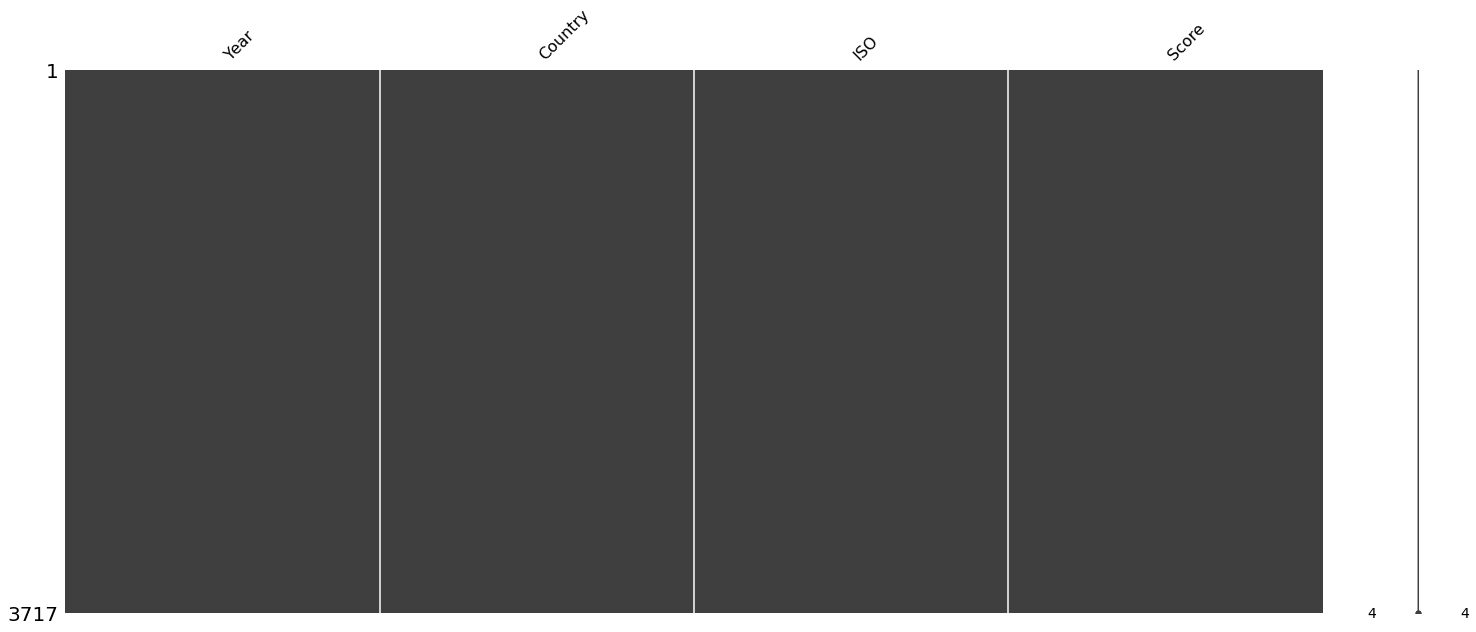

In [301]:
msno.matrix(data_transparency)
plt.show()

# Load worldbank dataset

## The CPIA Rating

As a second indicator on the level of corruption of a country we regarded the "CPIA transparency, accountability, and corruption in the public sector rating". Source: World Bank Group, CPIA database (http://www.worldbank.org/ida).
In the beginning we were determined to analyze this score in depth, but during the handling of the missing values it became obvious that too little data is available for the CPIA corruption rating in order to conclude meaningful information from it. Hence we decided to drop the whole column and focus on the CPI score.

In [302]:
worldbank_dataset_dir = 'Datasets/World Bank'

In [303]:
# load data csv
data = pd.read_csv(os.path.join(worldbank_dataset_dir, 'API_IQ.CPA.TRAN.XQ_DS2_en_csv_v2_3469422.csv'), skiprows=4)

# drop columns with all NaNs
data = data.dropna(axis = 1, how = 'all')
data.head()

,Country Name,Country Code,Indicator Name,Indicator Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,2.805556,2.750000,2.722222,2.694444,2.611111,2.555556,2.611111,2.578947,2.526316,2.555556,2.5,2.50,2.421053,2.5,2.500,2.500
2,Afghanistan,AFG,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,NaN,2.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.00,2.000000,2.0,2.000,2.000
3,Africa Western and Central,AFW,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,2.789474,2.789474,2.815789,2.789474,2.825000,2.850000,2.925000,2.825000,2.875000,2.900000,2.9,2.85,2.875000,2.9,2.925,2.925
4,Angola,AGO,"CPIA transparency, accountability, and corrupt...",IQ.CPA.TRAN.XQ,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [304]:
# drop irrelevant columns
data = data.drop(columns = [ 'Indicator Name', 'Indicator Code'])
data.head()

,Country Name,Country Code,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,Aruba,ABW,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Africa Eastern and Southern,AFE,2.805556,2.750000,2.722222,2.694444,2.611111,2.555556,2.611111,2.578947,2.526316,2.555556,2.5,2.50,2.421053,2.5,2.500,2.500
2,Afghanistan,AFG,NaN,2.500000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.0,2.00,2.000000,2.0,2.000,2.000
3,Africa Western and Central,AFW,2.789474,2.789474,2.815789,2.789474,2.825000,2.850000,2.925000,2.825000,2.875000,2.900000,2.9,2.85,2.875000,2.9,2.925,2.925
4,Angola,AGO,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,2.500000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [305]:
# stack the data
data_stacked = data.set_index(['Country Name', 'Country Code']).stack(dropna=False)
data_stacked

Country Name  Country Code      
Aruba         ABW           2005    NaN
                            2006    NaN
                            2007    NaN
                            2008    NaN
                            2009    NaN
                                   ... 
Zimbabwe      ZWE           2016    2.0
                            2017    2.0
                            2018    2.5
                            2019    2.5
                            2020    2.5
Length: 4256, dtype: float64

In [306]:
corruption_data = pd.DataFrame(data_stacked).reset_index()
# rename columns
corruption_data = corruption_data.rename(columns={"level_2": "Year", 0:'CPIA Rating'})
# shift column 'Name' to first position
first_column = corruption_data.pop('Country Code')
# insert column using insert(position,column_name,
# first_column) function
corruption_data.insert(0, 'Country Code', first_column)
#corruption_data = corruption_data.set_index('Country Name')
corruption_data.head()

,Country Code,Country Name,Year,CPIA Rating
0,ABW,Aruba,2005,NaN
1,ABW,Aruba,2006,NaN
2,ABW,Aruba,2007,NaN
3,ABW,Aruba,2008,NaN
4,ABW,Aruba,2009,NaN


In [307]:
# load metadata_country
metadata_country = pd.read_csv(os.path.join(worldbank_dataset_dir, 'Metadata_Country_API_IQ.CPA.TRAN.XQ_DS2_en_csv_v2_3469422.csv'))
metadata_country = metadata_country.drop(columns =['SpecialNotes','Unnamed: 5'])

In [308]:
# merge corruption_dat and metadata_country
merged_data = corruption_data.merge(metadata_country)
merged_data.drop(columns = ['TableName'], inplace = True)
merged_data.head()

,Country Code,Country Name,Year,CPIA Rating,Region,IncomeGroup
0,ABW,Aruba,2005,NaN,Latin America & Caribbean,High income
1,ABW,Aruba,2006,NaN,Latin America & Caribbean,High income
2,ABW,Aruba,2007,NaN,Latin America & Caribbean,High income
3,ABW,Aruba,2008,NaN,Latin America & Caribbean,High income
4,ABW,Aruba,2009,NaN,Latin America & Caribbean,High income


In [309]:
# get rid of none countries data
merged_data.dropna(subset=['Region', 'IncomeGroup'], how = 'all', inplace = True)

# shuffle the position of columns
merged_data.insert(2, 'Region', merged_data.pop('Region'))
merged_data.insert(3, 'IncomeGroup', merged_data.pop('IncomeGroup'))

In [310]:
# shift column 'Name' to first position
first_column = merged_data.pop('Country Name')
# insert column using insert(position,column_name,
# first_column) function
merged_data.insert(0, 'Country Name', first_column)
merged_data.head()

,Country Name,Country Code,Region,IncomeGroup,Year,CPIA Rating
0,Aruba,ABW,Latin America & Caribbean,High income,2005,NaN
1,Aruba,ABW,Latin America & Caribbean,High income,2006,NaN
2,Aruba,ABW,Latin America & Caribbean,High income,2007,NaN
3,Aruba,ABW,Latin America & Caribbean,High income,2008,NaN
4,Aruba,ABW,Latin America & Caribbean,High income,2009,NaN


In [311]:
# shift column 'Name' to first position
first_column = merged_data.pop('Year')
# insert column using insert(position,column_name,
# first_column) function
merged_data.insert(0, 'Year', first_column)
merged_data.head()

,Year,Country Name,Country Code,Region,IncomeGroup,CPIA Rating
0,2005,Aruba,ABW,Latin America & Caribbean,High income,NaN
1,2006,Aruba,ABW,Latin America & Caribbean,High income,NaN
2,2007,Aruba,ABW,Latin America & Caribbean,High income,NaN
3,2008,Aruba,ABW,Latin America & Caribbean,High income,NaN
4,2009,Aruba,ABW,Latin America & Caribbean,High income,NaN


In [312]:
# rename columns to match the transparency internation dataset
data_worldbank = merged_data.rename(columns={'Country Name': 'Country', 'Country Code':'ISO', 'Region':'Region_worldbank'})
data_worldbank.head()

,Year,Country,ISO,Region_worldbank,IncomeGroup,CPIA Rating
0,2005,Aruba,ABW,Latin America & Caribbean,High income,NaN
1,2006,Aruba,ABW,Latin America & Caribbean,High income,NaN
2,2007,Aruba,ABW,Latin America & Caribbean,High income,NaN
3,2008,Aruba,ABW,Latin America & Caribbean,High income,NaN
4,2009,Aruba,ABW,Latin America & Caribbean,High income,NaN


In [313]:
# Check for duplicate 'Country' in each year
df = data_worldbank
countryCounts = pd.DataFrame(columns=['Country','Count'])

for year in range(2000, 2021):
    df1 = df.loc[df['Year'] == year]
    country_counts = df1['Country'].value_counts().rename_axis('Country').reset_index(name= str(year) + ' Count')
    df1 = pd.DataFrame(country_counts)
    countryCounts = pd.merge(countryCounts, df1, on='Country', how='outer')

countryCounts.drop('Count', axis=1, inplace=True)
countryCounts = countryCounts.fillna(0)
countryCounts.replace(1.0, '', inplace=True)
countryCounts.replace(0, '', inplace=True)
countryCounts = countryCounts.set_index('Country')
countryCounts = countryCounts[countryCounts.any(1)] # remove empty rows
countryCounts

,2000 Count,2001 Count,2002 Count,2003 Count,2004 Count,2005 Count,2006 Count,2007 Count,2008 Count,2009 Count,2010 Count,2011 Count,2012 Count,2013 Count,2014 Count,2015 Count,2016 Count,2017 Count,2018 Count,2019 Count,2020 Count
Country,,,,,,,,,,,,,,,,,,,,,


In [314]:
# Check for duplicate 'ISO' in each year
df = data_worldbank
isoCounts = pd.DataFrame(columns=['ISO','Count'])

for year in range(2000, 2021):
    df1 = df.loc[df['Year'] == year]
    country_counts = df1['ISO'].value_counts().rename_axis('ISO').reset_index(name= str(year) + ' Count')
    df1 = pd.DataFrame(country_counts)
    isoCounts = pd.merge(isoCounts, df1, on='ISO', how='outer')

isoCounts.drop('Count', axis=1, inplace=True)
isoCounts = isoCounts.fillna(0)
isoCounts.replace(1.0, '', inplace=True)
isoCounts.replace(0, '', inplace=True)
isoCounts = isoCounts.set_index('ISO')
isoCounts = isoCounts[isoCounts.any(1)] # remove empty rows
isoCounts

,2000 Count,2001 Count,2002 Count,2003 Count,2004 Count,2005 Count,2006 Count,2007 Count,2008 Count,2009 Count,2010 Count,2011 Count,2012 Count,2013 Count,2014 Count,2015 Count,2016 Count,2017 Count,2018 Count,2019 Count,2020 Count
ISO,,,,,,,,,,,,,,,,,,,,,


In [315]:
# Check the worldbank dataframe
data_worldbank = data_worldbank.sort_values(['Year', 'ISO'])
data_worldbank.head()

,Year,Country,ISO,Region_worldbank,IncomeGroup,CPIA Rating
0,2005,Aruba,ABW,Latin America & Caribbean,High income,NaN
32,2005,Afghanistan,AFG,South Asia,Low income,NaN
64,2005,Angola,AGO,Sub-Saharan Africa,Lower middle income,2.5
80,2005,Albania,ALB,Europe & Central Asia,Upper middle income,3.0
96,2005,Andorra,AND,Europe & Central Asia,High income,NaN


In [316]:
# writing to csv file
data_worldbank.to_csv("Datasets/World Bank/data_worldbank.csv", index=False, encoding='utf-8-sig')

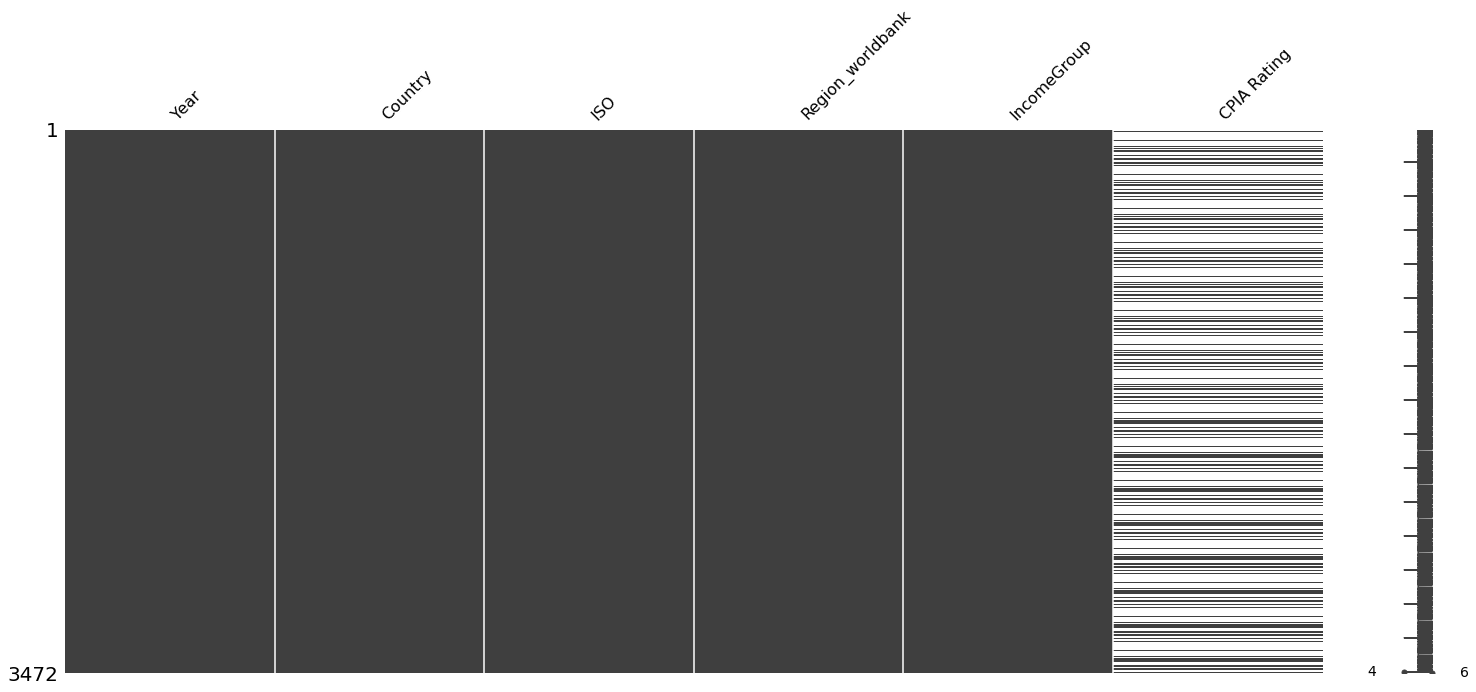

In [317]:
msno.matrix(data_worldbank)
plt.show()

# Merge tranparency and worldbank datasets

In [318]:
# Change worldbank df Year to int
data_worldbank['Year'] = data_worldbank['Year'].astype(int)
data_worldbank.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3472 entries, 0 to 4239
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Year              3472 non-null   int64  
 1   Country           3472 non-null   object 
 2   ISO               3472 non-null   object 
 3   Region_worldbank  3472 non-null   object 
 4   IncomeGroup       3456 non-null   object 
 5   CPIA Rating       1217 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 189.9+ KB


In [319]:
# merge tranparency and worldbank dataset
transparency_worldbank = pd.merge( data_transparency, data_worldbank, on=['Year','ISO'], how='outer')
transparency_worldbank.sort_values(by=['Year','ISO'])

,Year,Country_x,ISO,Score,Country_y,Region_worldbank,IncomeGroup,CPIA Rating
0,2000,Afghanistan,AFG,25.0,NaN,NaN,NaN,NaN
1,2000,Angola,AGO,17.0,NaN,NaN,NaN,NaN
2,2000,Albania,ALB,25.0,NaN,NaN,NaN,NaN
3,2000,United Arab Emirates,ARE,52.0,NaN,NaN,NaN,NaN
4,2000,Argentina,ARG,35.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
4388,2020,NaN,XKX,NaN,Kosovo,Europe & Central Asia,Upper middle income,3.0
3713,2020,Yemen,YEM,15.0,"Yemen, Rep.",Middle East & North Africa,Low income,1.5
3714,2020,South Africa,ZAF,44.0,South Africa,Sub-Saharan Africa,Upper middle income,NaN
3715,2020,Zambia,ZMB,33.0,Zambia,Sub-Saharan Africa,Lower middle income,2.5


In [320]:
transparency_worldbank = transparency_worldbank.drop(columns='Country_x')
transparency_worldbank = transparency_worldbank.rename(columns={'Country_y':'Country'})
transparency_worldbank.head()

,Year,ISO,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating
0,2000,AFG,25.0,NaN,NaN,NaN,NaN
1,2000,AGO,17.0,NaN,NaN,NaN,NaN
2,2000,ALB,25.0,NaN,NaN,NaN,NaN
3,2000,ARE,52.0,NaN,NaN,NaN,NaN
4,2000,ARG,35.0,NaN,NaN,NaN,NaN


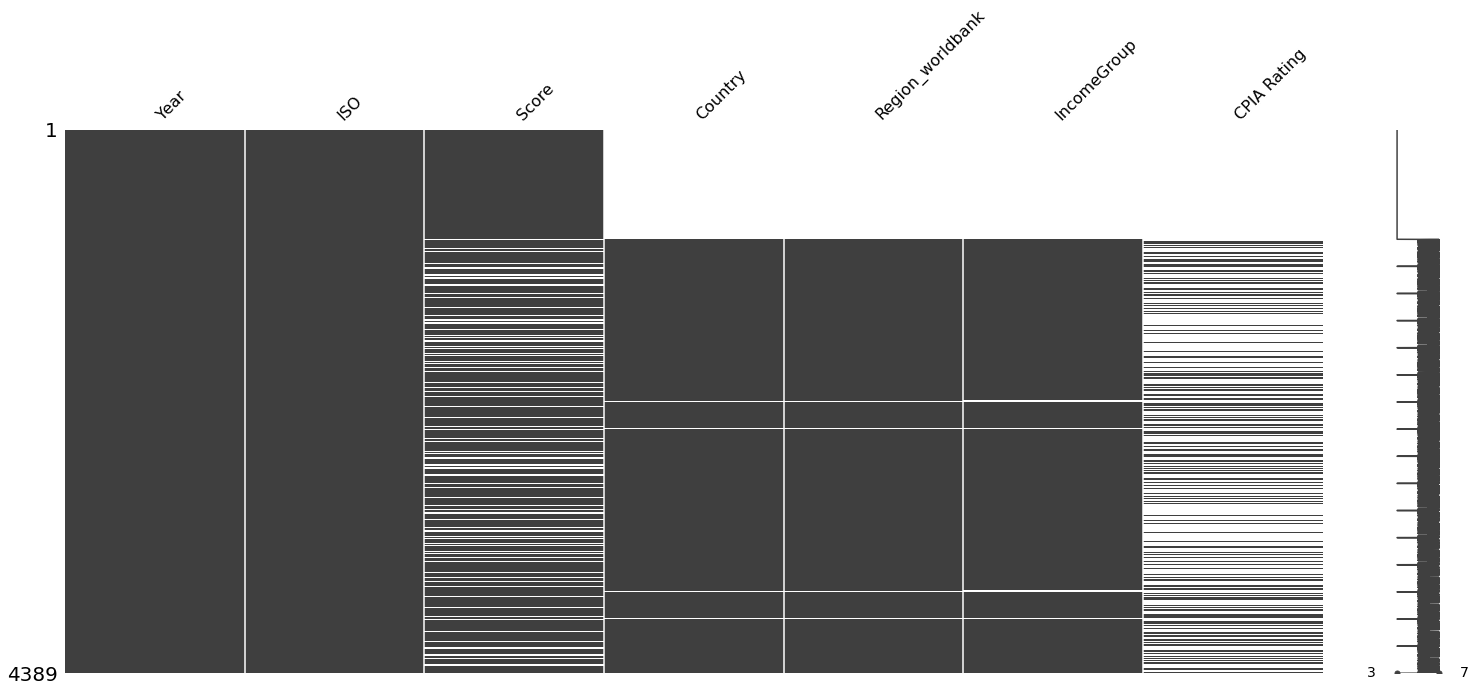

In [321]:
# Check missing data in the combined worldbank+transparency dataset
msno.matrix(transparency_worldbank.sort_values(by=['Year','Country']))
plt.show()

In [322]:
# Inspect unique countries
# we see 'nan' values
transparency_worldbank['Country'].unique()

array([nan, 'Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Australia', 'Austria', 'Azerbaijan',
       'Burundi', 'Belgium', 'Benin', 'Burkina Faso', 'Bangladesh',
       'Bulgaria', 'Bahrain', 'Bosnia and Herzegovina', 'Belarus',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada', 'Switzerland',
       'Chile', 'China', "Cote d'Ivoire", 'Cameroon', 'Congo, Dem. Rep.',
       'Congo, Rep.', 'Colombia', 'Comoros', 'Cabo Verde', 'Costa Rica',
       'Cuba', 'Cyprus', 'Czech Republic', 'Germany', 'Djibouti',
       'Dominica', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador',
       'Egypt, Arab Rep.', 'Eritrea', 'Spain', 'Estonia', 'Ethiopia',
       'Finland', 'France', 'Gabon', 'United Kingdom', 'Georgia', 'Ghana',
       'Guinea', 'Gambia, The', 'Guinea-Bissau', 'Equatorial Guinea',
       'Greece', 'Grenada', 'Guatemala', 'Guyana', 'Hong Kong SAR, China',
    

In [323]:
transparency_worldbank.sort_values(by=['Year','ISO'])

,Year,ISO,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating
0,2000,AFG,25.0,NaN,NaN,NaN,NaN
1,2000,AGO,17.0,NaN,NaN,NaN,NaN
2,2000,ALB,25.0,NaN,NaN,NaN,NaN
3,2000,ARE,52.0,NaN,NaN,NaN,NaN
4,2000,ARG,35.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
4388,2020,XKX,NaN,Kosovo,Europe & Central Asia,Upper middle income,3.0
3713,2020,YEM,15.0,"Yemen, Rep.",Middle East & North Africa,Low income,1.5
3714,2020,ZAF,44.0,South Africa,Sub-Saharan Africa,Upper middle income,NaN
3715,2020,ZMB,33.0,Zambia,Sub-Saharan Africa,Lower middle income,2.5


# Show missing entries

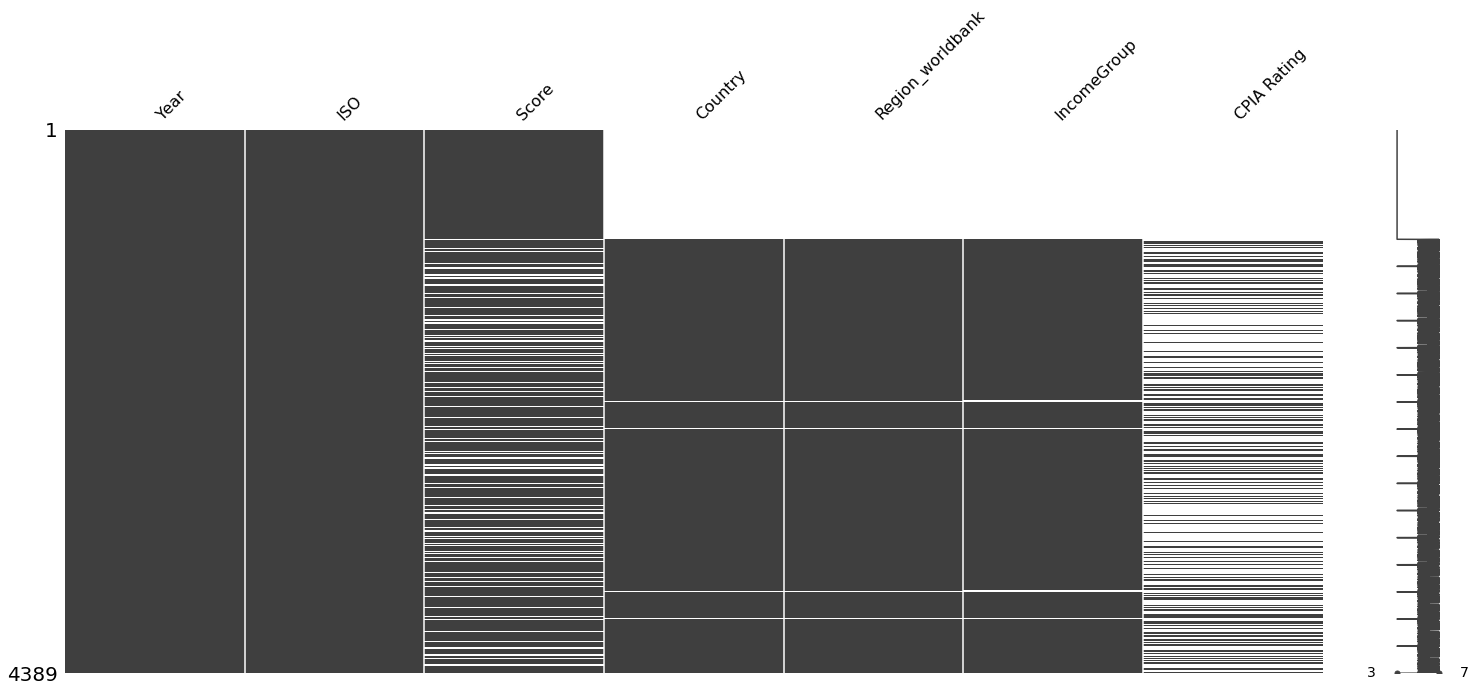

In [324]:
msno.matrix(transparency_worldbank.sort_values(by=['Year','Country']))
plt.show()

In [325]:
# Change types to string
transparency_worldbank['Region_worldbank']= (transparency_worldbank['Region_worldbank'].astype('str'))
np.unique(transparency_worldbank['Region_worldbank'])

transparency_worldbank['IncomeGroup']= (transparency_worldbank['IncomeGroup'].astype('str'))

# Loading attributes for correlation

## Deciding on correlating attributes

Attributes that we presume to correlate with the degree of corruption of a country are downloaded from the world bank data set and merged into one dataframe. All characteristics chosen show limitations in accuracy, either because of values that are only estimated, values that do not reflect actual circumstances in the countries, values that cannot be quantified objectively, etc. We chose the characteristics that seemed best for our use case from our perspective.
nformation on and reasons why we chose the data and: (All information and data from https://datacatalog.worldbank.org/public-licenses#cc-by)
#### 1. GDP:
- **Research Question**: Does the level of corruption negatively influence the GDP of a country?
- **Definition**: GDP at purchaser's prices is the sum of gross value added by all resident producers in the economy plus any product taxes and minus any subsidies not included in the value of the products. It is calculated without making deductions for depreciation of fabricated assets or for depletion and degradation of natural resources. Data are in current U.S. dollars. Dollar figures for GDP are converted from domestic currencies using single year official exchange rates. For a few countries where the official exchange rate does not reflect the rate effectively applied to actual foreign exchange transactions, an alternative conversion factor is used.
- **Source**: World Bank national accounts data, and OECD National Accounts data files.


#### 2. Gender Equality:
- **Research Question**: Do countries with higher corruption rates also miss in promoting gender equality measurements?
- **Definition**: Gender equality assesses the extent to which the country has installed institutions and programs to enforce laws and policies that promote equal access for men and women in education, health, the economy, and protection under law.
- **Source**: World Bank Group, CPIA database (http://www.worldbank.org/ida).


#### 3. Government expenditure on education:
- **Research Question**: Do countries where good education is not a high priority lean to higher corruption levels?
- **Definition**: General government expenditure on education (current, capital, and transfers) is expressed as a percentage of GDP. It includes expenditure funded by transfers from international sources to government. General government usually refers to local, regional and central governments.
- **Source**: UNESCO Institute for Statistics (http://uis.unesco.org/). Data as of September 2021.


#### 4. Political Stability and Absence of Violence/Terrorism:
- **Research Question**: Is corruption linked to violence and political instability in a country?
- **Definition**: Political Stability and Absence of Violence/Terrorism measures perceptions of the likelihood of political instability and/or politically-motivated violence, including terrorism. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5.
- **Source**: Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org. The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kraay (World Bank Development Research Group). Please cite Kaufmann, Daniel, Aart Kraay and Massimo Mastruzzi (2010). "The Worldwide Governance Indicators: Methodology and Analytical Issues". World Bank Policy Research Working Paper No. 5430 (http://papers.ssrn.com/sol3/papers.cfm?abstract_id=1682130). The WGI do not reflect the official views of the Natural Resource Governance Institute, the Brookings Institution, the World Bank, its Executive Directors, or the countries they represent.


#### 5. Regulatory Quality:
- **Research Question**: Is it harder for countries with high corruption rates to implement regulations for the private sector?
- **Definition**: Regulatory Quality captures perceptions of the ability of the government to formulate and implement sound policies and regulations that permit and promote private sector development. Estimate gives the country's score on the aggregate indicator, in units of a standard normal distribution, i.e. ranging from approximately -2.5 to 2.5.
- **Source**: Detailed documentation of the WGI, interactive tools for exploring the data, and full access to the underlying source data available at www.govindicators.org.The WGI are produced by Daniel Kaufmann (Natural Resource Governance Institute and Brookings Institution) and Aart Kraay (World Bank Development Research Group). Please cite Kaufmann, Daniel, Aart Kraay and Massimo Mastruzzi (2010). "The Worldwide Governance Indicators: Methodology and Analytical Issues". World Bank Policy Research Working Paper No. 5430 (http://papers.ssrn.com/sol3/papers.cfm?abstract_id=1682130). The WGI do not reflect the official views of the Natural Resource Governance Institute, the Brookings Institution, the World Bank, its Executive Directors, or the countries they represent.


#### 6. Unemployment:
- **Research Question**: Do countries with high unemployment rates tend to be more corrupted than those with lower unemployment?
- **Definition**: Unemployment refers to the share of the labor force that is without work but available for and seeking employment.
- **Source**: 	International Labour Organization, ILOSTAT database. Data retrieved on June 15, 2021.


#### 7. Population:
- **Research Question**: Is the corruption rate correlated to the population of a country? 
- **Definition**: Total population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship. The values shown are midyear estimates.
- **Source**: 	(1) United Nations Population Division. World Population Prospects: 2019 Revision. (2) Census reports and other statistical publications from national statistical offices, (3) Eurostat: Demographic Statistics, (4) United Nations Statistical Division. Population and Vital Statistics Reprot (various years), (5) U.S. Census Bureau: International Database, and (6) Secretariat of the Pacific Community: Statistics and Demography Programme.

### New Datasets
#### 8. Ease of Doing Business
- **Research Question**: Is the ease of doing business better regulated in countries with lower corruption rates than in countries with higher corruption rates? 
- **Definition**: The ease of doing business scores benchmark economies with respect to regulatory best practice, showing the proximity to the best regulatory performance on each Doing Business indicator. An economy’s score is indicated on a scale from 0 to 100, where 0 represents the worst regulatory performance and 100 the best regulatory performance.
- **Source**: World Bank, Doing Business project (http://www.doingbusiness.org/).

#### 9. Renewable Energy Consumption
- **Research Question**: Is renewable energy consumption lower in corrupt countries?
- **Definition**: Renewable energy consumption is the share of renewables energy in total final energy consumption
- **Source**:	World Bank, Sustainable Energy for All (SE4ALL) database from the SE4ALL Global Tracking Framework led jointly by the World Bank, International Energy Agency, and the Energy Sector Management Assistance Program.


#### 10. Population Growth
- **Research Question**: How is the corruption rate correlated to the population growth of a country? 
- **Definition**: Annual population growth rate. Population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship.
- **Source**: 	Derived from total population. Population source: (1) United Nations Population Division. World Population Prospects: 2019 Revision, (2) Census reports and other statistical publications from national statistical offices, (3) Eurostat: Demographic Statistics, (4) United Nations Statistical Division. Population and Vital Statistics Reprot (various years), (5) U.S. Census Bureau: International Database, and (6) Secretariat of the Pacific Community: Statistics and Demography Programme.

#### 11. Population Density
- **Research Question**: How is the corruption rate correlated to the population density of a country? 
- **Definition**: Population density is midyear population divided by land area in square kilometers. Population is based on the de facto definition of population, which counts all residents regardless of legal status or citizenship--except for refugees not permanently settled in the country of asylum, who are generally considered part of the population of their country of origin. Land area is a country's total area, excluding area under inland water bodies, national claims to continental shelf, and exclusive economic zones. In most cases the definition of inland water bodies includes major rivers and lakes.
- **Source**: Food and Agriculture Organization and World Bank population estimates.

#### 12. Expenditure on Military
- **Research Question**: Do corrupt countries spend more money on military than less corrupt countries? 
- **Definition**: Military expenditures data from SIPRI are derived from the NATO definition, which includes all current and capital expenditures on the armed forces, including peacekeeping forces; defense ministries and other government agencies engaged in defense projects; paramilitary forces, if these are judged to be trained and equipped for military operations; and military space activities. Such expenditures include military and civil personnel, including retirement pensions of military personnel and social services for personnel; operation and maintenance; procurement; military research and development; and military aid (in the military expenditures of the donor country). Excluded are civil defense and current expenditures for previous military activities, such as for veterans' benefits, demobilization, conversion, and destruction of weapons. This definition cannot be applied for all countries, however, since that would require much more detailed information than is available about what is included in military budgets and off-budget military expenditure items. (For example, military budgets might or might not cover civil defense, reserves and auxiliary forces, police and paramilitary forces, dual-purpose forces such as military and civilian police, military grants in kind, pensions for military personnel, and social security contributions paid by one part of government to another.)
- **Source**: Stockholm International Peace Research Institute (SIPRI), Yearbook: Armaments, Disarmament and International Security.

#### 13. Land Area
- **Research Question**: Do countries with large land areas indicate higher corruption rates than smaller countries?
- **Definition**: Land area is a country's total area, excluding area under inland water bodies, national claims to continental shelf, and exclusive economic zones. In most cases the definition of inland water bodies includes major rivers and lakes.
- **Source**: Food and Agriculture Organization, electronic files and web site.

#### 14. Alcohol Consumption
- **Research Question**: Do countries with high corruption rates also have large average alcohol consumptions?
- **Definition**: Total alcohol per capita consumption is defined as the total (sum of recorded and unrecorded alcohol) amount of alcohol consumed per person (15 years of age or older) over a calendar year, in litres of pure alcohol, adjusted for tourist consumption.
- **Source**: World Health Organization, Global Health Observatory Data Repository (http://apps.who.int/ghodata/).

#### 15. Life Expectancy
- **Research Question**: Do people that live in countries with high corruption rates have smaller life expectancies?
- **Definition**: Life expectancy at birth indicates the number of years a newborn infant would live if prevailing patterns of mortality at the time of its birth were to stay the same throughout its life.
- **Source**: 	(1) United Nations Population Division. World Population Prospects: 2019 Revision, or derived from male and female life expectancy at birth from sources such as: (2) Census reports and other statistical publications from national statistical offices, (3) Eurostat: Demographic Statistics, (4) United Nations Statistical Division. Population and Vital Statistics Reprot (various years), (5) U.S. Census Bureau: International Database, and (6) Secretariat of the Pacific Community: Statistics and Demography Programme.

#### 16. Inflation
- **Research Question**: Is inflation more likely to increase in corrupt countries?
- **Definition**: Inflation as measured by the consumer price index reflects the annual percentage change in the cost to the average consumer of acquiring a basket of goods and services that may be fixed or changed at specified intervals, such as yearly. The Laspeyres formula is generally used.
- **Source**: International Monetary Fund, International Financial Statistics and data files.

#### 17. Infant Mortality
- **Research Question**: Do countries with high corruption rates also have high infant mortality rates?
- **Definition**: 	Infant mortality rate is the number of infants dying before reaching one year of age, per 1,000 live births in a given year.
- **Source**: 	Estimates developed by the UN Inter-agency Group for Child Mortality Estimation (UNICEF, WHO, World Bank, UN DESA Population Division) at www.childmortality.org.

#### 18. Suicide Rate
- **Research Question**: Do countries with high corruption rates also have high suicide rates?
- **Definition**: Suicide mortality rate is the number of suicide deaths in a year per 100,000 population. Crude suicide rate (not age-adjusted).
- **Source**: World Health Organization, Global Health Observatory Data Repository (http://apps.who.int/ghodata/).


All data was downloaded for all countries available in the world bank data set and for the years 2000 to 2020. The data sets **Regulatory Quality** and **Political Stability and Absence of Violence/Terrorism** are from the data base **Worldwide Governance Indicators**, all others from **World Development Indicators**. Screenshots on how the data is to be downloaded from the world bank data bases can be found in the document "worldbank_download.pdf" in the folder with the data sets.

In [326]:
wb_attr_dataset_dir = './Datasets/World Bank - Correlating Attributes'            
        
def merge_correlating_attributes():
    df_dict = {}
    for filename in os.listdir(wb_attr_dataset_dir):
        # load dataframes for every data set
        if filename.endswith(".csv"):
            df_dict[filename] = load_correlating_attributes(filename)
    gdp_df = df_dict["GDP.csv"]
    gender_df = df_dict["gender_equality.csv"]
    education_df = df_dict["expenditure_on_education.csv"]
    stability_df = df_dict["political_stability.csv"]
    regulatory_df = df_dict["regulatory_quality.csv"]
    unemployment_df = df_dict["unemployment.csv"]
    population_df = df_dict["Population.csv"]
    dfs = [gdp_df, gender_df, education_df, stability_df, regulatory_df, unemployment_df, population_df]
    
    # merge the dataframes with all correlating attributes
    merged_attributes = dfs[0].join(dfs[1:])
    return merged_attributes

def load_correlating_attributes(filename):
    # load data
    data = pd.read_csv(os.path.join(wb_attr_dataset_dir, filename))
    
    # save series name for naming columns
    attr_name = data['Series Name'].iloc[1]
    data = data.drop(columns = ['Series Code','Series Name'])    
    
    # stack data
    data_stacked = data.set_index(['Country Name', 'Country Code']).stack(dropna=False)
    
    # create dataframe and change column names, set index etc.
    corr_attr_data = pd.DataFrame(data_stacked).reset_index()
    corr_attr_data = corr_attr_data.rename(columns={"level_2": "Year", 0:attr_name})
    first_column = corr_attr_data.pop('Country Code')
    corr_attr_data.insert(0, 'Country Code', first_column)
    corr_attr_data['Year'] = corr_attr_data['Year'].str.split('[', 1, expand=True)
    corr_attr_data = corr_attr_data.sort_values(by=['Country Code', 'Year'])
    corr_attr_data = corr_attr_data.set_index(['Country Code','Country Name','Year'])
    return corr_attr_data

attributes_data = merge_correlating_attributes()
attributes_data

GDP per capita (current US$)  ... Population (total)
Country Code Country Name Year                                ...                   
ABW          Aruba        2000              20617.7504673528  ...              90866
                          2001              20670.3670051627  ...              92892
                          2002              20436.8871286309  ...              94992
                          2003               20833.976357295  ...              97016
                          2004              22568.3749910043  ...              98744
...                                                      ...  ...                ...
ZWE          Zimbabwe     2016              1464.58895715841  ...           14030338
                          2017              1235.18903192064  ...           14236599
                          2018              1254.64226494434  ...           14438812
                          2019              1316.74065692871  ...           14645473
                          2020              1214.50982023534  ...           14862927

[4557 rows x 7 columns]

In [327]:
transparency_worldbank

,Year,ISO,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating
0,2000,AFG,25.0,NaN,nan,nan,NaN
1,2000,AGO,17.0,NaN,nan,nan,NaN
2,2000,ALB,25.0,NaN,nan,nan,NaN
3,2000,ARE,52.0,NaN,nan,nan,NaN
4,2000,ARG,35.0,NaN,nan,nan,NaN
...,...,...,...,...,...,...,...
4384,2020,TUV,NaN,Tuvalu,East Asia & Pacific,Upper middle income,3.5
4385,2020,VGB,NaN,British Virgin Islands,Latin America & Caribbean,High income,NaN
4386,2020,VIR,NaN,Virgin Islands (U.S.),Latin America & Caribbean,High income,NaN
4387,2020,WSM,NaN,Samoa,East Asia & Pacific,Lower middle income,4.0


In [328]:
# Reindex, rename, change type
attributes_df = attributes_data.reset_index()
attributes_df = attributes_df.rename(columns={"Country Code": "ISO"})
attributes_df['Year'] = attributes_df['Year'].astype(int)
corruption_df = transparency_worldbank.reset_index()
corruption_df.head()

,index,Year,ISO,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating
0,0,2000,AFG,25.0,NaN,nan,nan,NaN
1,1,2000,AGO,17.0,NaN,nan,nan,NaN
2,2,2000,ALB,25.0,NaN,nan,nan,NaN
3,3,2000,ARE,52.0,NaN,nan,nan,NaN
4,4,2000,ARG,35.0,NaN,nan,nan,NaN


# Merge new attributes onto the dataframe

In [329]:
# Merge the new attributes to the corruption dataframe
merged_df = pd.merge(corruption_df, attributes_df,  on=['ISO','Year'], how='outer')
corruption_correlations = merged_df.set_index(['ISO','Year'])

corruption_correlations.drop(columns='Country Name', inplace=True)
corruption_correlations.reset_index(inplace=True)
corruption_correlations.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total)
0,AFG,2000,0.0,25.0,NaN,nan,nan,NaN,..,..,..,-2.440187,-2.109626,11.65,20779957
1,AGO,2000,1.0,17.0,NaN,nan,nan,NaN,556.838631674927,..,2.60753011703491,-2.035583,-1.799331,3.87,16395477
2,ALB,2000,2.0,25.0,NaN,nan,nan,NaN,1126.68334010717,..,3.4301700592041,-0.5379785,-0.2543595,16.58,3089027
3,ARE,2000,3.0,52.0,NaN,nan,nan,NaN,33291.3662541838,..,..,0.9751094,0.7285935,2.25,3134067
4,ARG,2000,4.0,35.0,NaN,nan,nan,NaN,7708.09911454041,..,4.58030986785889,0.0993588,0.2572446,15,36870796


## Loading further attributes for correlation (ease of doing business)


In [330]:
# Adding an additional attribute
wb_attr_dataset_dir = './Datasets/Easy To Doing Businesess' 

df = pd.read_excel (os.path.join(wb_attr_dataset_dir,'Ease of Doing Business.xlsx'), header=[1])
df.drop(columns=['Ease of doing business rank'],inplace=True)
df = df.dropna(axis = 0, subset=['Economy'])

cols = ['Ease of doing business score (DB17-20 methodology)', 'Ease of doing business score (DB15 methodology)', 'Ease of doing business score (DB10-14 methodology)']
df.loc[:,cols] = df.loc[:,cols].ffill(axis = 1)
df.loc[:,cols] = df.loc[:,cols].bfill(axis = 1)

data_ease_of_business = df.drop(columns=['Ease of doing business score (DB15 methodology)', 'Ease of doing business score (DB10-14 methodology)'])
data_ease_of_business.rename(columns={"Country code":"ISO","Economy":"Country","Income group":"IncomeGroup","DB Year":"Year","Region":"Region_worldbank","Ease of doing business score (DB17-20 methodology)": "Ease of doing business score "},inplace = True)

# convert  year column to int
data_ease_of_business['Year'] = data_ease_of_business['Year'].astype(int)
data_ease_of_business.head()

,ISO,Country,Region_worldbank,IncomeGroup,Year,Ease of doing business score
0,AFG,Afghanistan,South Asia,Low income,2020,44.06497
1,AFG,Afghanistan,South Asia,Low income,2019,44.20343
2,AFG,Afghanistan,South Asia,Low income,2018,37.13062
3,AFG,Afghanistan,South Asia,Low income,2017,38.93563
4,AFG,Afghanistan,South Asia,Low income,2016,39.25519


In [331]:
# handling missing values
df_ordering = data_ease_of_business.sort_values(by =['Country', 'Year'])
data_ease_of_business = df_ordering.interpolate(method="linear", limit_direction="both")

data_ease_of_business.head()

,ISO,Country,Region_worldbank,IncomeGroup,Year,Ease of doing business score
16,AFG,Afghanistan,South Asia,Low income,2004,39.68895
15,AFG,Afghanistan,South Asia,Low income,2005,39.68895
14,AFG,Afghanistan,South Asia,Low income,2006,39.68895
13,AFG,Afghanistan,South Asia,Low income,2007,39.68895
12,AFG,Afghanistan,South Asia,Low income,2008,39.68895


In [332]:
# Merge the new attribute to the main dataframe
updated_corruption_correlations = pd.merge(corruption_correlations, data_ease_of_business,  on=['ISO','Year','Country','Region_worldbank','IncomeGroup'], how='outer')
updated_corruption_correlations.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score
0,AFG,2000,0.0,25.0,NaN,nan,nan,NaN,..,..,..,-2.440187,-2.109626,11.65,20779957,NaN
1,AGO,2000,1.0,17.0,NaN,nan,nan,NaN,556.838631674927,..,2.60753011703491,-2.035583,-1.799331,3.87,16395477,NaN
2,ALB,2000,2.0,25.0,NaN,nan,nan,NaN,1126.68334010717,..,3.4301700592041,-0.5379785,-0.2543595,16.58,3089027,NaN
3,ARE,2000,3.0,52.0,NaN,nan,nan,NaN,33291.3662541838,..,..,0.9751094,0.7285935,2.25,3134067,NaN
4,ARG,2000,4.0,35.0,NaN,nan,nan,NaN,7708.09911454041,..,4.58030986785889,0.0993588,0.2572446,15,36870796,NaN


## Adding new attributes (10 New)

In [333]:
# Adding 10 new attributes
wb_attr_dataset_dir = './Datasets/World Bank - Correlating Attributes/' 

def merge_new_attributes():
    df_dict = {}
    for filename in os.listdir(wb_attr_dataset_dir):
        # load dataframes for every data set
        if filename.endswith(".csv"):
            df_dict[filename] = load_correlating_attributes(filename)
            df_dict[filename].reset_index(inplace=True)
      
    dfa = df_dict["renewable_cons.csv"]
    dfb = df_dict["pop_growth.csv"]
    dfc = df_dict["pop_density.csv"]
    dfd = df_dict["military.csv"]
    dfe = df_dict["land_area.csv"]
    dff = df_dict["alcohol_cons.csv"]
    dfg = df_dict["life_expectancy.csv"]
    dfh = df_dict["inflation.csv"]
    dfi = df_dict["infant_mortality.csv"]
    dfj = df_dict["suicide.csv"]
    dfs = [dfa, dfb, dfc, dfd, dfe, dff, dfg, dfh, dfi, dfj]

    # merge the dataframes with all correlating attributes
    data_new = [dfs[0],dfs[1].iloc[:,3:4],dfs[2].iloc[:,3:4],dfs[3].iloc[:,3:4],dfs[4].iloc[:,3:4],dfs[5].iloc[:,3:4],dfs[6].iloc[:,3:4],dfs[7].iloc[:,3:4],dfs[8].iloc[:,3:4],dfs[9].iloc[:,3:4]]
    df_10new = pd.concat(data_new, axis=1)

    return df_10new

df_10new = merge_new_attributes()
df_10new.rename(columns={"Country Code":"ISO","Country Name":"Country"}, inplace=True)
df_10new['Year'] = df_10new['Year'].astype(int)
df_10new.drop(columns=['Country'],inplace=True)

wb_attr_dataset_dir = './Datasets/Easy To Doing Businesess'  # just to restore how it was

df_10new.head(10)

,ISO,Year,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,ABW,2000,0.175300002,2.06484,504.8111111,..,180,..,73.787,4.044021312,..,..
1,ABW,2001,0.180500001,2.20516,516.0666667,..,180,..,73.853,2.883604303,..,..
2,ABW,2002,0.181400001,2.23551,527.7333333,..,180,..,73.937,3.315246786,..,..
3,ABW,2003,0.184599996,2.10832,538.9777778,..,180,..,74.038,3.656365079,..,..
4,ABW,2004,0.187099993,1.76547,548.5777778,..,180,..,74.156,2.529129469,..,..
5,ABW,2005,0.1866,1.29195,555.7111111,..,180,..,74.287,3.397786778,..,..
6,ABW,2006,0.189899996,0.798578,560.1666667,..,180,..,74.429,3.608024388,..,..
7,ABW,2007,0.189999998,0.391971,562.3666667,..,180,..,74.576,5.392567845,..,..
8,ABW,2008,0.193499997,0.134263,563.1222222,..,180,..,74.725,8.955987052,..,..
9,ABW,2009,0.299800009,0.0887513,563.6222222,..,180,..,74.872,-2.13542872,..,..


In [334]:
# Merge the new attributes to the main dataframe
new_updated_corruption_correlations = pd.merge(updated_corruption_correlations, df_10new,  on=['ISO','Year'], how='outer')
new_updated_corruption_correlations.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,AFG,2000,0.0,25.0,NaN,nan,nan,NaN,..,..,..,-2.440187,-2.109626,11.65,20779957,NaN,54.24319839,2.97506,31.8291165,..,652860,..,55.841,..,90.2,4.9
1,AGO,2000,1.0,17.0,NaN,nan,nan,NaN,556.838631674927,..,2.60753011703491,-2.035583,-1.799331,3.87,16395477,NaN,73.44110107,3.27722,13.15110051,6.392603154,1246700,2.76,46.522,324.9968716,121.2,8.7
2,ALB,2000,2.0,25.0,NaN,nan,nan,NaN,1126.68334010717,..,3.4301700592041,-0.5379785,-0.2543595,16.58,3089027,NaN,41.44499969,-0.637357,112.7382117,1.246360242,27400,6.57,73.955,0.050018136,24.1,4.9
3,ARE,2000,3.0,52.0,NaN,nan,nan,NaN,33291.3662541838,..,..,0.9751094,0.7285935,2.25,3134067,NaN,0.076399997,5.51075,44.12935793,8.323722245,71020,2.58,74.327,..,9.6,8.6
4,ARG,2000,4.0,35.0,NaN,nan,nan,NaN,7708.09911454041,..,4.58030986785889,0.0993588,0.2572446,15,36870796,NaN,9.847999573,1.10061,13.47277039,1.148822677,2736690,8.75,73.576,..,17.5,9.1


# Handling missing values on the final dataframe

In [335]:
# Copy the main dataframe and check
corruption_correlations = new_updated_corruption_correlations.copy()

## Check completeness of each attribute

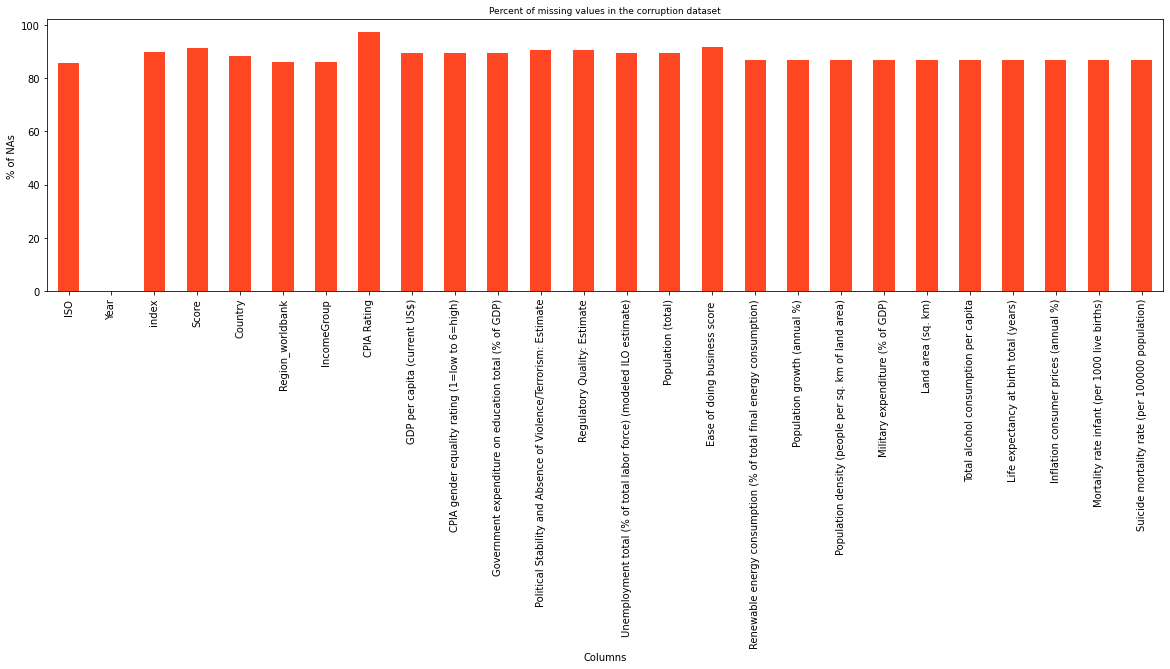

In [336]:
percent_missing_cols = corruption_correlations.isna().sum() / corruption_correlations.shape[0] * 100
ax = percent_missing_cols.plot.bar(figsize=(20,5), 
                              title='Percent of missing values in the corruption dataset', 
                              ylabel='% of NAs', xlabel='Columns')


In [337]:
# Check number of NAs
corruption_correlations.isna().sum()

ISO                                                                   36540
Year                                                                      0
index                                                                 38354
Score                                                                 39026
Country                                                               37667
Region_worldbank                                                      36750
IncomeGroup                                                           36750
CPIA Rating                                                           41526
GDP per capita (current US$)                                          38186
CPIA gender equality rating (1=low to 6=high)                         38228
Government expenditure on education total (% of GDP)                  38228
Political Stability and Absence of Violence/Terrorism: Estimate       38683
Regulatory Quality: Estimate                                          38683
Unemployment

In [338]:
# Sort by year and ISO, reindex
df_mv3 = corruption_correlations.sort_values(by =['ISO', 'Year'])
df_mv3 = df_mv3.reset_index(drop=True)

df_mv3.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,ABW,2000,NaN,NaN,NaN,NaN,NaN,NaN,20617.7504673528,..,4.71468019485474,..,..,..,90866,NaN,0.175300002,2.06484,504.8111111,..,180,..,73.787,4.044021312,..,..
1,ABW,2001,NaN,NaN,NaN,NaN,NaN,NaN,20670.3670051627,..,4.73986005783081,NaN,NaN,..,92892,NaN,0.180500001,2.20516,516.0666667,..,180,..,73.853,2.883604303,..,..
2,ABW,2002,NaN,NaN,NaN,NaN,NaN,NaN,20436.8871286309,..,4.92364978790283,..,..,..,94992,NaN,0.181400001,2.23551,527.7333333,..,180,..,73.937,3.315246786,..,..
3,ABW,2003,NaN,NaN,NaN,NaN,NaN,NaN,20833.976357295,..,..,..,..,..,97016,NaN,0.184599996,2.10832,538.9777778,..,180,..,74.038,3.656365079,..,..
4,ABW,2004,NaN,NaN,NaN,NaN,NaN,NaN,22568.3749910043,..,4.40848016738892,0.9938546,0.7719577,..,98744,NaN,0.187099993,1.76547,548.5777778,..,180,..,74.156,2.529129469,..,..


In [339]:
# Check for the string 'nan' in busisness column
df_mv3[df_mv3['Ease of doing business score '].isna()]

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,ABW,2000,NaN,NaN,NaN,NaN,NaN,NaN,20617.7504673528,..,4.71468019485474,..,..,..,90866,NaN,0.175300002,2.06484,504.8111111,..,180,..,73.787,4.044021312,..,..
1,ABW,2001,NaN,NaN,NaN,NaN,NaN,NaN,20670.3670051627,..,4.73986005783081,NaN,NaN,..,92892,NaN,0.180500001,2.20516,516.0666667,..,180,..,73.853,2.883604303,..,..
2,ABW,2002,NaN,NaN,NaN,NaN,NaN,NaN,20436.8871286309,..,4.92364978790283,..,..,..,94992,NaN,0.181400001,2.23551,527.7333333,..,180,..,73.937,3.315246786,..,..
3,ABW,2003,NaN,NaN,NaN,NaN,NaN,NaN,20833.976357295,..,..,..,..,..,97016,NaN,0.184599996,2.10832,538.9777778,..,180,..,74.038,3.656365079,..,..
4,ABW,2004,NaN,NaN,NaN,NaN,NaN,NaN,22568.3749910043,..,4.40848016738892,0.9938546,0.7719577,..,98744,NaN,0.187099993,1.76547,548.5777778,..,180,..,74.156,2.529129469,..,..
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
42738,NaN,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42739,NaN,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42740,NaN,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42741,NaN,2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [340]:
# Deleting the rows with missing values in the column "Score"
# Explanation: The missing values are allways complete countries, so there is no use for further purposes
df_mv4 = df_mv3.dropna(subset=["Score"], axis=0, how='all')
df_mv4.isnull().sum()

ISO                                                                      0
Year                                                                     0
index                                                                    0
Score                                                                    0
Country                                                                917
Region_worldbank                                                         0
IncomeGroup                                                              0
CPIA Rating                                                           2599
GDP per capita (current US$)                                            42
CPIA gender equality rating (1=low to 6=high)                           63
Government expenditure on education total (% of GDP)                    63
Political Stability and Absence of Violence/Terrorism: Estimate        237
Regulatory Quality: Estimate                                           237
Unemployment total (% of 

In [341]:
# Reset index to get the correct index for the initial dataset
df_mv5=df_mv4.reset_index(drop=True)
# This dataframe is the inital dataset to get rid of the missing values in the correlating attributes
df_mv5.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,AFG,2000,0.0,25.0,NaN,nan,nan,NaN,..,..,..,-2.440187,-2.109626,11.65,20779957,NaN,54.24319839,2.97506,31.8291165,..,652860,..,55.841,..,90.2,4.9
1,AFG,2001,177.0,25.0,NaN,nan,nan,NaN,..,..,..,NaN,NaN,11.63,21606992,NaN,54.05500031,3.9028,33.09590418,..,652860,..,56.308,..,87.6,5
2,AFG,2002,354.0,25.0,NaN,nan,nan,NaN,179.426579211394,..,..,-2.035389,-1.804449,11.68,22600774,NaN,43.77119827,4.49672,34.61810189,..,652860,..,56.784,..,84.9,5
3,AFG,2003,531.0,25.0,NaN,nan,nan,NaN,190.683814295088,..,..,-2.197809,-1.430002,11.68,23680871,NaN,42.27610016,4.66834,36.27251019,..,652860,..,57.271,..,82.3,5
4,AFG,2004,708.0,25.0,NaN,nan,nan,NaN,211.382074198939,..,..,-2.296179,-1.505863,11.61,24726689,NaN,49.84320068,4.32156,37.87441258,2.431257869,652860,..,57.772,..,79.6,5


In [342]:
# Chosen method to fill the missing values in the correlating attributes = Interpolate
# Check dtypes of columns before the interpolation
df_mv5.dtypes

ISO                                                                    object
Year                                                                    int64
index                                                                 float64
Score                                                                 float64
Country                                                                object
Region_worldbank                                                       object
IncomeGroup                                                            object
CPIA Rating                                                           float64
GDP per capita (current US$)                                           object
CPIA gender equality rating (1=low to 6=high)                          object
Government expenditure on education total (% of GDP)                   object
Political Stability and Absence of Violence/Terrorism: Estimate        object
Regulatory Quality: Estimate                                    

## Filling missing values by interpolation




In [343]:
# Change dtypes of the columns, which are going to be interpolated
df_mv6 = df_mv5.copy()

df_mv6['GDP per capita (current US$)'] = pd.to_numeric(df_mv4['GDP per capita (current US$)'], errors = 'coerce')
df_mv6['CPIA gender equality rating (1=low to 6=high)'] = pd.to_numeric(df_mv4['CPIA gender equality rating (1=low to 6=high)'], errors = 'coerce')
df_mv6['Government expenditure on education total (% of GDP)'] = pd.to_numeric(df_mv4['Government expenditure on education total (% of GDP)'], errors = 'coerce')
df_mv6['Political Stability and Absence of Violence/Terrorism: Estimate'] = pd.to_numeric(df_mv4['Political Stability and Absence of Violence/Terrorism: Estimate'], errors = 'coerce')
df_mv6['Regulatory Quality: Estimate'] = pd.to_numeric(df_mv4['Regulatory Quality: Estimate'], errors = 'coerce')
df_mv6['Unemployment total (% of total labor force) (modeled ILO estimate)'] = pd.to_numeric(df_mv4['Unemployment total (% of total labor force) (modeled ILO estimate)'], errors = 'coerce')
df_mv6['Population (total)'] = pd.to_numeric(df_mv4['Population (total)'], errors = 'coerce')
df_mv6['Renewable energy consumption (% of total final energy consumption)'] = pd.to_numeric(df_mv4['Renewable energy consumption (% of total final energy consumption)'], errors = 'coerce')
df_mv6['Military expenditure (% of GDP)'] = pd.to_numeric(df_mv4['Military expenditure (% of GDP)'], errors = 'coerce')
df_mv6['Land area (sq. km)'] = pd.to_numeric(df_mv4['Land area (sq. km)'], errors = 'coerce')
df_mv6['Total alcohol consumption per capita'] = pd.to_numeric(df_mv4['Total alcohol consumption per capita'], errors = 'coerce')
df_mv6['Life expectancy at birth total (years)'] = pd.to_numeric(df_mv4['Life expectancy at birth total (years)'], errors = 'coerce')
df_mv6['Inflation consumer prices (annual %)'] = pd.to_numeric(df_mv4['Inflation consumer prices (annual %)'], errors = 'coerce')
df_mv6['Mortality rate infant (per 1000 live births)'] = pd.to_numeric(df_mv4['Mortality rate infant (per 1000 live births)'], errors = 'coerce')
df_mv6['Suicide mortality rate (per 100000 population)'] = pd.to_numeric(df_mv4['Suicide mortality rate (per 100000 population)'], errors = 'coerce')
df_mv6['Population growth (annual %)'] = pd.to_numeric(df_mv4['Population growth (annual %)'], errors = 'coerce')
df_mv6['Population density (people per sq. km of land area)'] = pd.to_numeric(df_mv4['Population density (people per sq. km of land area)'], errors = 'coerce')

df_mv6.dtypes

ISO                                                                    object
Year                                                                    int64
index                                                                 float64
Score                                                                 float64
Country                                                                object
Region_worldbank                                                       object
IncomeGroup                                                            object
CPIA Rating                                                           float64
GDP per capita (current US$)                                          float64
CPIA gender equality rating (1=low to 6=high)                         float64
Government expenditure on education total (% of GDP)                  float64
Political Stability and Absence of Violence/Terrorism: Estimate       float64
Regulatory Quality: Estimate                                    

In [344]:
# Interpolation of columns with NaN values
df_mv7=df_mv6[["GDP per capita (current US$)","CPIA gender equality rating (1=low to 6=high)", "Government expenditure on education total (% of GDP)", "Political Stability and Absence of Violence/Terrorism: Estimate",
               "Regulatory Quality: Estimate", "Unemployment total (% of total labor force) (modeled ILO estimate)","Population (total)", "Ease of doing business score ","Renewable energy consumption (% of total final energy consumption)","Population growth (annual %)","Population density (people per sq. km of land area)","Military expenditure (% of GDP)","Land area (sq. km)","Total alcohol consumption per capita","Life expectancy at birth total (years)","Inflation consumer prices (annual %)","Mortality rate infant (per 1000 live births)","Suicide mortality rate (per 100000 population)"]].interpolate(methode="linear", limit_direction="both")

df_mv7.head()

,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
1,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
2,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
3,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
4,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9


In [345]:
# Update the initial dataframe to fill the NaN values with the interpolated values
df_mv6.update(df_mv7)
df_mv6.sort_values(by =['ISO', 'Year'], inplace=True)

df_mv6.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,AFG,2000,0.0,25.0,NaN,nan,nan,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
1,AFG,2001,177.0,25.0,NaN,nan,nan,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
2,AFG,2002,354.0,25.0,NaN,nan,nan,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
3,AFG,2003,531.0,25.0,NaN,nan,nan,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
4,AFG,2004,708.0,25.0,NaN,nan,nan,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9


## Filling missing nominal data by lookup table

In [346]:
### Check for the string 'nan' in IncomeGroup Column

# Each country is missing the first 5 values for IncomeGroup
# These will be backwards filled

# VEN, TWN, KSV are missing 21 values (all years)
# These will be estimated based on GDP and similar income groups, and manually added

# KSV lower middle income
# VEN upper middle income
# TWN lower middle income

df_mv6.loc[df_mv6['IncomeGroup'] == "nan"]

df = df_mv6.groupby(['ISO','IncomeGroup']).size().reset_index().rename(columns={0:'count'})
df.loc[df['IncomeGroup'] == "nan"]

,ISO,IncomeGroup,count
1,AFG,nan,5
3,AGO,nan,5
5,ALB,nan,5
7,ARE,nan,5
9,ARG,nan,5
...,...,...,...
342,VUT,nan,5
344,YEM,nan,5
346,ZAF,nan,5
348,ZMB,nan,5


In [347]:
## manually add income group for VEN, KSV, TWN 
df_mv6.loc[df_mv6['ISO'] == 'VEN', 'IncomeGroup'] = 'Upper middle income'
df_mv6.loc[df_mv6['ISO'] == 'KSV', 'IncomeGroup'] = 'Lower middle income'
df_mv6.loc[df_mv6['ISO'] == 'TWN', 'IncomeGroup'] = 'Lower middle income'

df_mv6.sort_values(by =['ISO', 'Year'], inplace=True)

# Delete all 'nan' strings from IncomeGroup column
df_mv6['IncomeGroup'] = df_mv6['IncomeGroup'].replace('nan', np.nan)

# Fill missing IncomeGroup with backward fill
df_mv6['IncomeGroup'] = df_mv6.groupby('ISO')['IncomeGroup'].fillna(method='bfill')

df_mv6.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,AFG,2000,0.0,25.0,NaN,nan,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
1,AFG,2001,177.0,25.0,NaN,nan,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
2,AFG,2002,354.0,25.0,NaN,nan,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
3,AFG,2003,531.0,25.0,NaN,nan,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
4,AFG,2004,708.0,25.0,NaN,nan,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9


In [348]:
# Fill in missing "Country" and "Region_worldbank"

# (1) Create a dictionary of ISO:Country pairs
# iso_dict was created in Load Transparency International Dataset, Handle missing values
country_dict= {value : key for (key, value) in iso_dict.items()}

# (2) Create a dictionary of ISO:Region_worldbank pairs
regions=df_mv6[['ISO','Region_worldbank']].dropna()
regions.drop_duplicates(inplace=True)
regions = regions[~regions.Region_worldbank.str.contains("nan")] # nan are strings
region_dict = dict(zip(regions.ISO, regions.Region_worldbank))

# these regions are missing in the datasets, and must be added manually
region_dict.update({'KSV': "Europe & Central Asia"})
region_dict.update({'TWN': "East Asia & Pacific"})

In [349]:
# Fill missing Countries
df_filled = df_mv6.copy()

df_filled["Country"] = df_filled["ISO"].map(country_dict)
df_filled["Region_worldbank"] = df_filled["ISO"].map(region_dict)

df_filled.head()

,ISO,Year,index,Score,Country,Region_worldbank,IncomeGroup,CPIA Rating,GDP per capita (current US$),CPIA gender equality rating (1=low to 6=high),Government expenditure on education total (% of GDP),Political Stability and Absence of Violence/Terrorism: Estimate,Regulatory Quality: Estimate,Unemployment total (% of total labor force) (modeled ILO estimate),Population (total),Ease of doing business score,Renewable energy consumption (% of total final energy consumption),Population growth (annual %),Population density (people per sq. km of land area),Military expenditure (% of GDP),Land area (sq. km),Total alcohol consumption per capita,Life expectancy at birth total (years),Inflation consumer prices (annual %),Mortality rate infant (per 1000 live births),Suicide mortality rate (per 100000 population)
0,AFG,2000,0.0,25.0,Afghanistan,South Asia,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
1,AFG,2001,177.0,25.0,Afghanistan,South Asia,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
2,AFG,2002,354.0,25.0,Afghanistan,South Asia,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
3,AFG,2003,531.0,25.0,Afghanistan,South Asia,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9
4,AFG,2004,708.0,25.0,Afghanistan,South Asia,Low income,NaN,179.426579,2.0,3.47945,-2.440187,-2.109626,11.65,20779957.0,39.68895,54.243198,2.975057,31.829116,2.431258,652860.0,0.21,55.841,12.686269,90.2,4.9


In [350]:
# Check the final dataframe for NaN's
corruption_correlations_cleaned = df_filled.drop(columns=['CPIA Rating', 'index'])
corruption_correlations_cleaned.isnull().sum()
# Dateframe is cleaned

ISO                                                                   0
Year                                                                  0
Score                                                                 0
Country                                                               0
Region_worldbank                                                      0
IncomeGroup                                                           0
GDP per capita (current US$)                                          0
CPIA gender equality rating (1=low to 6=high)                         0
Government expenditure on education total (% of GDP)                  0
Political Stability and Absence of Violence/Terrorism: Estimate       0
Regulatory Quality: Estimate                                          0
Unemployment total (% of total labor force) (modeled ILO estimate)    0
Population (total)                                                    0
Ease of doing business score                                    

# Initial data exploration using the final dataframe

In [351]:
# Rename columns so they're easier to read and graph
corruption_correlations_cleaned.rename(columns = {'Region_worldbank':'Region',
                    'IncomeGroup':'Income Group',
                    'GDP per capita (current US$)':'GDP',
                    'CPIA gender equality rating (1=low to 6=high)':'Gender Equality',
                    'Government expenditure on education total (% of GDP)':'Education Expenditure',
                    'Political Stability and Absence of Violence/Terrorism: Estimate':'Political Stability',
                    'Regulatory Quality: Estimate':'Regulatory Quality',
                    'Unemployment total (% of total labor force) (modeled ILO estimate)':'Unemployment',
                    'Population (total)':'Population',
                    'Ease of doing business score ':'Ease of Doing Business',
                    'Renewable energy consumption (% of total final energy consumption)':'Renewable Energy Consumption',
                    'Population growth (annual %)':'Population Growth',
                    'Population density (people per sq. km of land area)':'Population Density',
                    'Military expenditure (% of GDP)':'Military Expenditure',
                    'Land area (sq. km)':'Land Area',
                    'Total alcohol consumption per capita':'Alcohol Consumption',
                    'Life expectancy at birth total (years)':'Life Expectancy',
                    'Inflation consumer prices (annual %)':'Inflation',
                    'Mortality rate infant (per 1000 live births)':'Infant Mortality',
                    'Suicide mortality rate (per 100000 population)':'Suicide rate'}, inplace = True)

## Visualize feature distributions

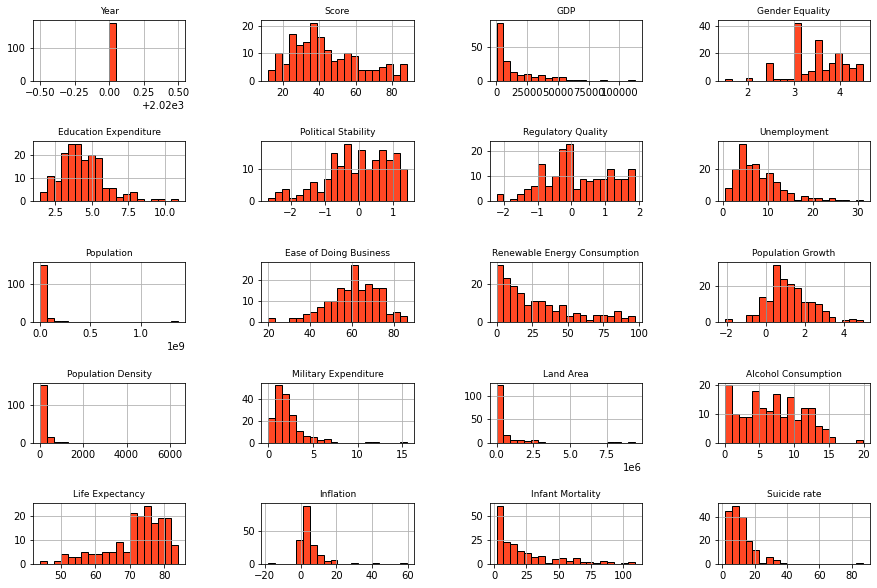

In [352]:
# Histograms of Numeric Data
df = corruption_correlations_cleaned

yr = 2020  # pick a year
df = df[df["Year"] == yr]

plt.rcParams["axes.titlesize"] = 9
df.hist(bins= 20, figsize= (15,10), edgecolor="black")
plt.subplots_adjust(hspace=1, wspace=0.5) 

plt.show()

## Visualize outliers in boxplots

In [353]:
df = corruption_correlations_cleaned

yr = 2020  # pick a year
df = df[df["Year"] == yr] 
vars = list(df.columns) 

fig = make_subplots(rows=5, cols=4, 
                    horizontal_spacing=0.1,
                    vertical_spacing=0.1)

for i, var in enumerate(vars):
  if i < 4:        
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row = 1, col=i+1
    )

  if 4 <= i < 8:        
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row = 2, col=i-3
    )

  if 8 <= i < 12:        
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row = 3, col=i-7
    )

  if 12 <= i < 16:        
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row = 4, col=i-11
    )

  if 16 <= i < 20:        
    fig.add_trace(
        go.Box(y=df[var],
        name=var),
        row = 5, col=i-15
    )
fig.update_layout(title_text="Boxplots for " + str(yr), height=1000, width=1500)
fig.update_traces(boxpoints='all')

# Check for correlations


In [354]:
# calcuate correlation matrix
df_corr = corruption_correlations_cleaned.corr(method='pearson')
df_corr.head()

,Year,Score,GDP,Gender Equality,Education Expenditure,Political Stability,Regulatory Quality,Unemployment,Population,Ease of Doing Business,Renewable Energy Consumption,Population Growth,Population Density,Military Expenditure,Land Area,Alcohol Consumption,Life Expectancy,Inflation,Infant Mortality,Suicide rate
Year,1.000000,0.064884,-0.000012,-0.002534,-0.005917,0.009101,0.004339,-0.005486,-0.002723,-0.022034,-0.002170,0.013296,0.005041,-0.006482,-0.003789,-0.006753,0.005802,-0.013959,-0.009374,0.004612
Score,0.064884,1.000000,-0.045636,-0.040975,-0.097850,-0.041236,-0.022936,-0.039926,0.096466,0.200882,-0.021731,0.076939,-0.004877,-0.031429,0.104351,-0.023799,-0.046423,-0.033767,0.000267,-0.111490
GDP,-0.000012,-0.045636,1.000000,-0.040204,0.237220,0.604082,0.730182,-0.148028,-0.114064,0.112270,-0.330071,-0.101408,0.084038,-0.089041,0.010782,0.469791,0.608021,-0.149630,-0.504649,0.142158
Gender Equality,-0.002534,-0.040975,-0.040204,1.000000,0.161639,0.204665,0.116377,0.107700,-0.192220,0.038714,-0.127688,-0.196546,0.013099,0.079708,-0.091623,0.168033,0.162001,-0.070502,-0.257257,0.053064
Education Expenditure,-0.005917,-0.097850,0.237220,0.161639,1.000000,0.345046,0.261045,0.092828,-0.094259,0.035753,-0.202127,-0.234417,-0.102853,0.032847,0.015997,0.285638,0.257877,-0.089779,-0.327212,0.265039


## Visualizations of the correlation matrix


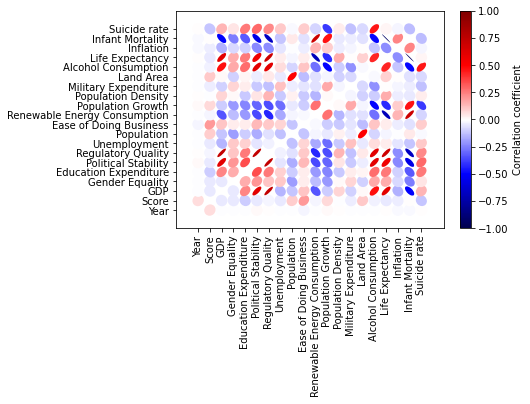

In [355]:
def plot_corr_ellipses(data, ax=None, **kwargs):

    M = np.array(data)
    if not M.ndim == 2:
        raise ValueError('data must be a 2D array')
    if ax is None:
        fig, ax = plt.subplots(1, 1, subplot_kw={'aspect':'equal'})
        ax.set_xlim(-0.5, M.shape[1] - 0.5)
        ax.set_ylim(-0.5, M.shape[0] - 0.5)

    # xy locations of each ellipse center
    xy = np.indices(M.shape)[::-1].reshape(2, -1).T

    # set the relative sizes of the major/minor axes according to the strength of
    # the positive/negative correlation
    w = np.ones_like(M).ravel()
    h = 1 - np.abs(M).ravel()
    a = 45 * np.sign(M).ravel()

    ec = EllipseCollection(widths=w, heights=h, angles=a, units='x', offsets=xy,
                           transOffset=ax.transData, array=M.ravel(), **kwargs)
    ax.add_collection(ec)

    # if data is a DataFrame, use the row/column names as tick labels
    if isinstance(data, pd.DataFrame):
        ax.set_xticks(np.arange(M.shape[1]))
        ax.set_xticklabels(data.columns, rotation=90)
        ax.set_yticks(np.arange(M.shape[0]))
        ax.set_yticklabels(data.index)

    return ec

# Negative correlations can be plotted as ellipses with the opposite orientation

fig, ax = plt.subplots(1, 1)
m = plot_corr_ellipses(df_corr, ax=ax, cmap='seismic', clim=[-1, 1])
cb = fig.colorbar(m)
cb.set_label('Correlation coefficient')
ax.margins(0.1)
fig.show()

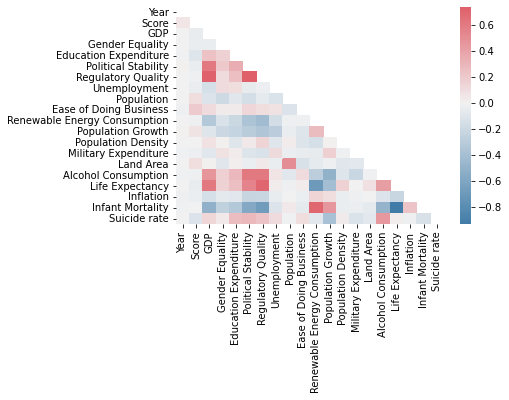

In [356]:
mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240,10, as_cmap=True)
sns.heatmap(df_corr, mask=mask, cmap=cmap, center=0)
plt.show()

# Visualizations

In [357]:
# Setting Year as a string to get rid of decimals for visualizations
corruption_correlations_cleaned.Year=corruption_correlations_cleaned.Year.astype('str')

## Average CPI score trend per region over the year

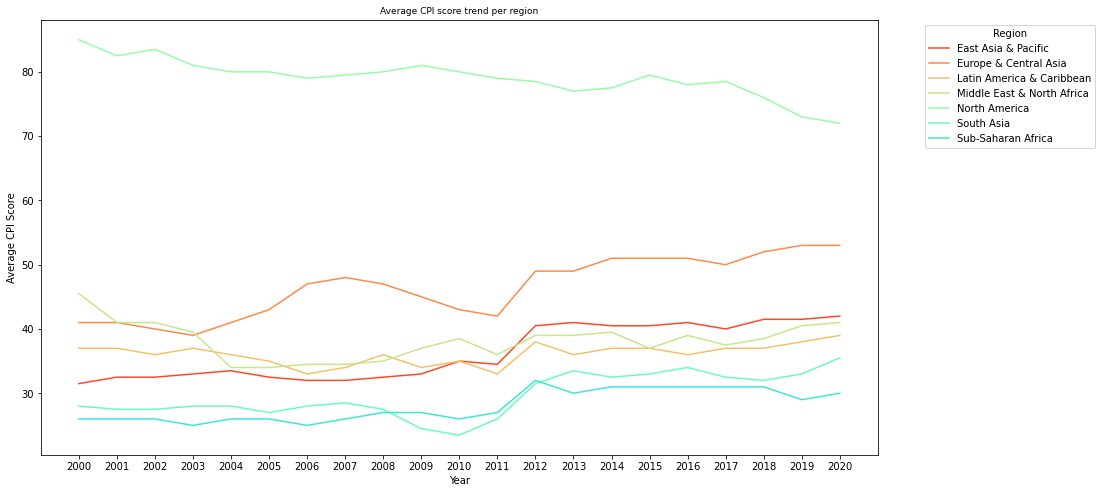

In [358]:
## Analysis based on Regions
df = corruption_correlations_cleaned.set_index('Year')
results = []
for y in np.unique(corruption_correlations_cleaned['Year']):
  df1 = (df.loc[y,['Region','Score']])
  for r in np.unique(corruption_correlations_cleaned['Region']):
    df2 = df1.loc[df1['Region']== r]
    average_score = df2['Score'].median()
    results.append([y,r,average_score])

res1 = pd.DataFrame(results)
res1.columns = ['Year', 'Region', 'Average Score']

plt.figure(figsize=(15, 8))
sns.lineplot(x="Year", y="Average Score", hue="Region", data=res1)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Average CPI Score')
plt.title('Average CPI score trend per region')
plt.show()

## Average CPI score trend per income group over the years

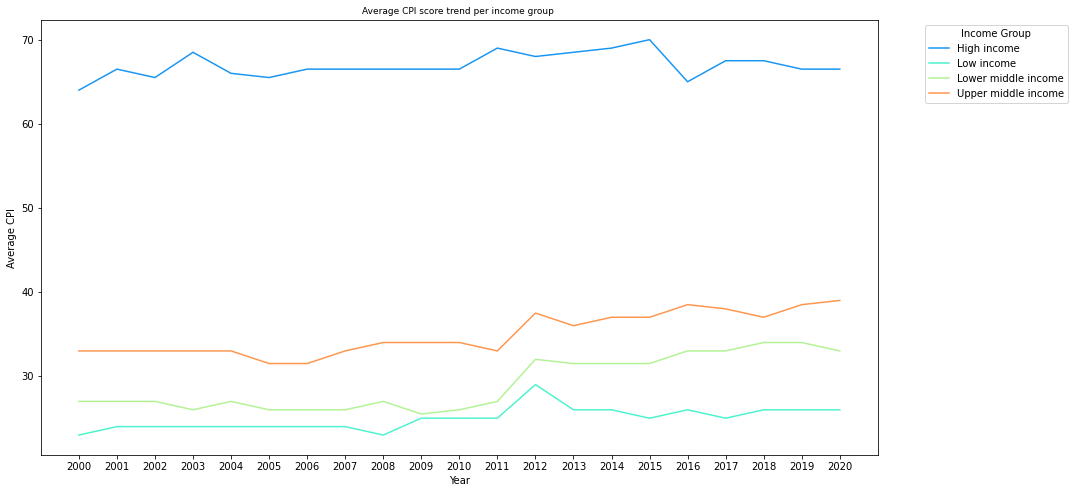

In [359]:
## Analysis based on Income Group
df = corruption_correlations_cleaned.set_index('Year')
results = []
for y in np.unique(corruption_correlations_cleaned['Year']):
  df1 = (df.loc[y,['Income Group','Score']])
  for r in np.unique(corruption_correlations_cleaned['Income Group']):
    df2 = df1.loc[df1['Income Group']== r]
    average_score = df2['Score'].median()
    min_score = df2['Score'].min()
    results.append([y,r,average_score,min_score])

res2 = pd.DataFrame(results)
res2.columns = ['Year', 'Income Group', 'Average Score', 'Min Score']
res2

plt.figure(figsize=(15, 8))
sns.lineplot(x="Year", y="Average Score", hue="Income Group", data=res2, palette= 'rainbow')
plt.legend(title='Income Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.ylabel('Average CPI')
plt.title('Average CPI score trend per income group ')
plt.show()

## Relationship between CPI and features (lineplots)

Text(0.5, 1.0, 'CPI over GDP')

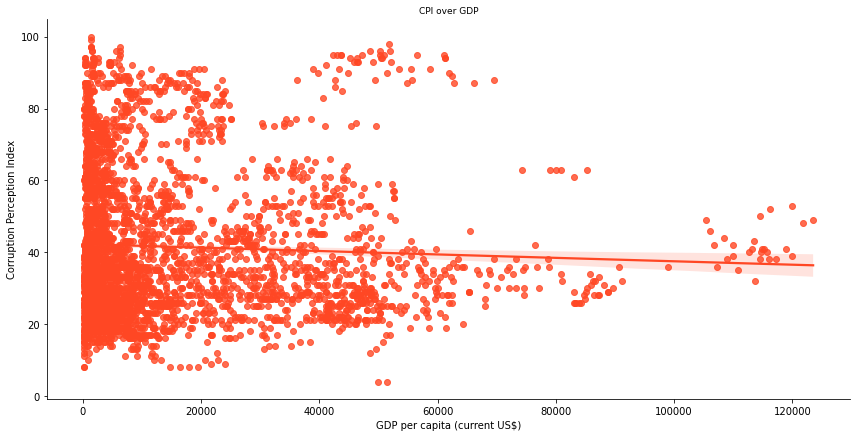

In [360]:
sns.lmplot(x='GDP', y='Score',data=corruption_correlations_cleaned, aspect=2, height=6)
plt.xlabel('GDP per capita (current US$)')
plt.ylabel('Corruption Perception Index')
plt.title('CPI over GDP')

Text(0.5, 1.0, 'CPI over Political Stability')

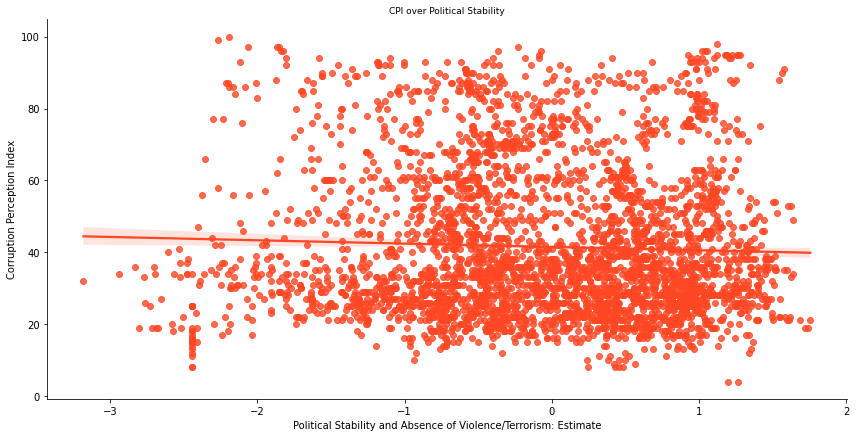

In [361]:
sns.lmplot(x='Political Stability', y='Score',data=corruption_correlations_cleaned, aspect=2, height=6)
plt.xlabel('Political Stability and Absence of Violence/Terrorism: Estimate')
plt.ylabel('Corruption Perception Index')
plt.title('CPI over Political Stability')

Text(0.5, 1.0, 'CPI over Regulatory Quality')

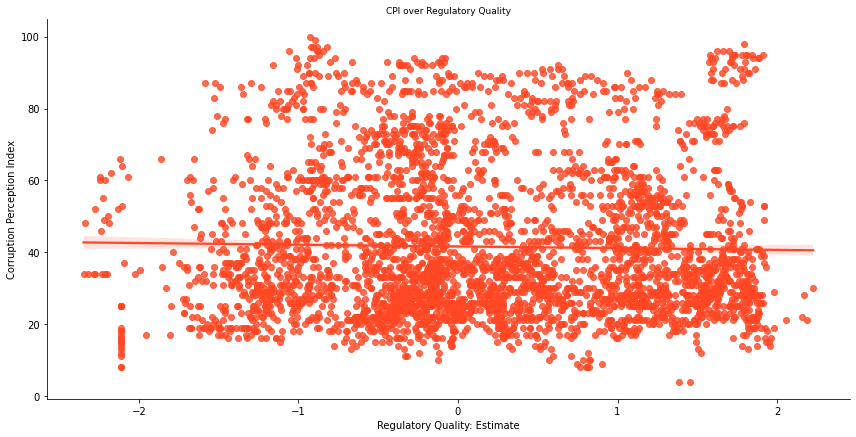

In [362]:
sns.lmplot(x='Regulatory Quality', y='Score',data=corruption_correlations_cleaned, aspect=2, height=6)
plt.xlabel('Regulatory Quality: Estimate')
plt.ylabel('Corruption Perception Index')
plt.title('CPI over Regulatory Quality')

Text(0.5, 1.0, 'CPI over Education')

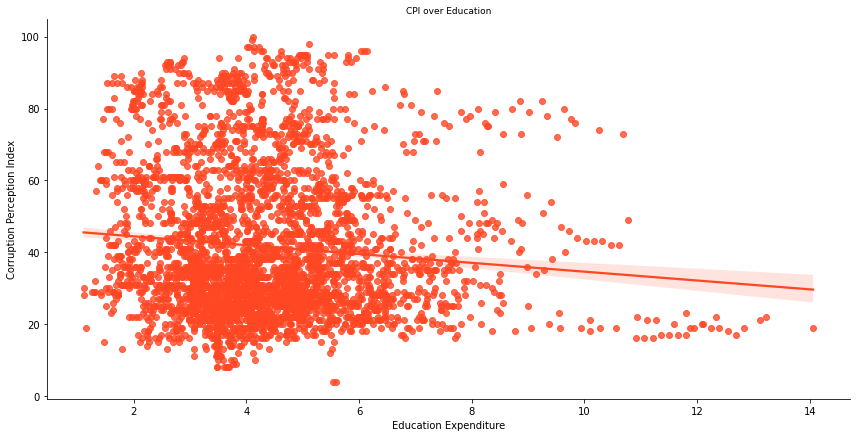

In [363]:
sns.lmplot(x='Education Expenditure', y='Score',data=corruption_correlations_cleaned, aspect=2, height=6)
plt.ylabel('Corruption Perception Index')
plt.title('CPI over Education')


Text(0.5, 1.0, 'CPI over Ease of doing business')

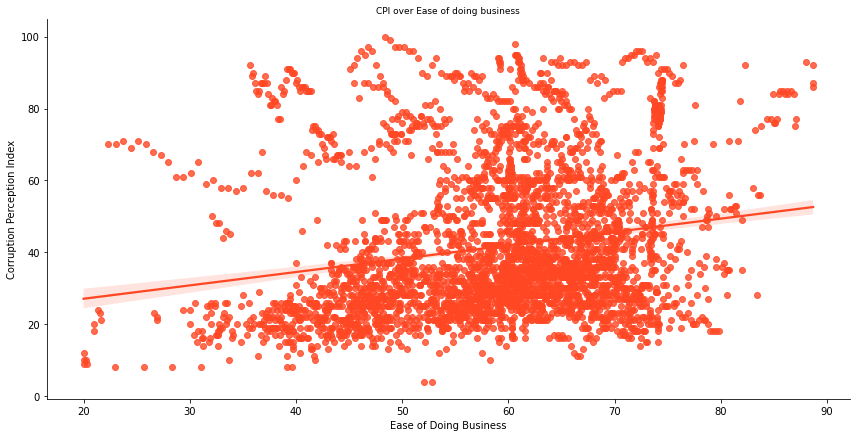

In [364]:
sns.lmplot(x='Ease of Doing Business', y='Score',data=corruption_correlations_cleaned, aspect=2, height=6)
plt.ylabel('Corruption Perception Index')
plt.title('CPI over Ease of doing business')

## Relationship between CPI and features (boxplots)

Text(0.5, 1.0, 'Box plot of CPI vs regions')

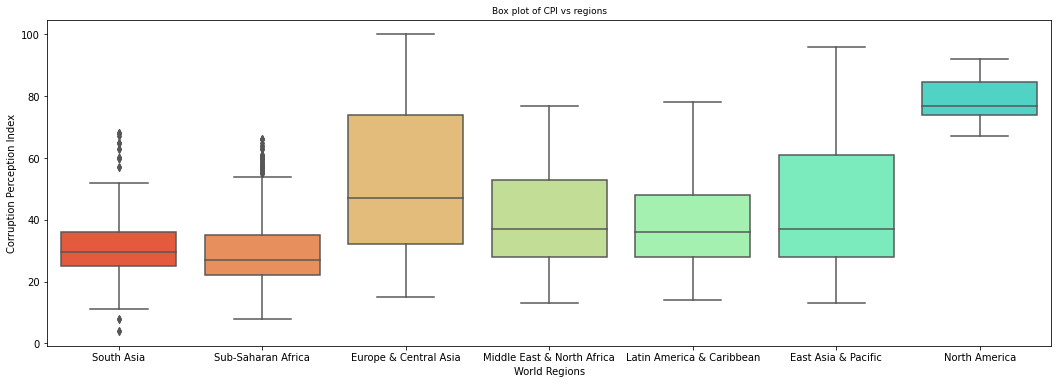

In [365]:
plt.figure(figsize=(18,6))
sns.set_palette(reversed(sns.color_palette("rainbow", 10)), 10)
sns.boxplot(x='Region', y='Score', data=corruption_correlations_cleaned )
plt.xlabel('World Regions')
plt.ylabel('Corruption Perception Index')
plt.title('Box plot of CPI vs regions')

Text(0.5, 1.0, 'Box plot of CPI vs income')

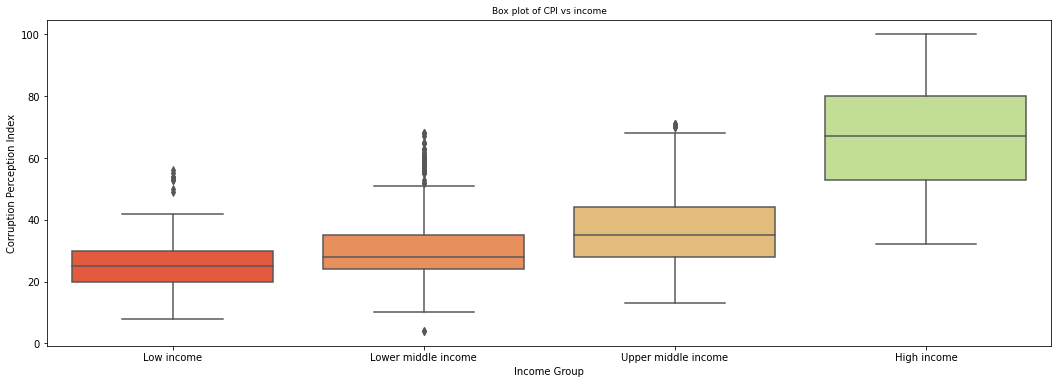

In [366]:
plt.figure(figsize=(18,6))
sns.set_palette(reversed(sns.color_palette("rainbow", 10)), 10)
sns.boxplot(x='Income Group', y='Score', data=corruption_correlations_cleaned,order=['Low income','Lower middle income','Upper middle income','High income'])
plt.xlabel('Income Group')
plt.ylabel('Corruption Perception Index')
plt.title('Box plot of CPI vs income')

## Relationship between CPI and features (scatterplots)

Text(0.5, 1.0, 'Scatter plot of CPI vs income')

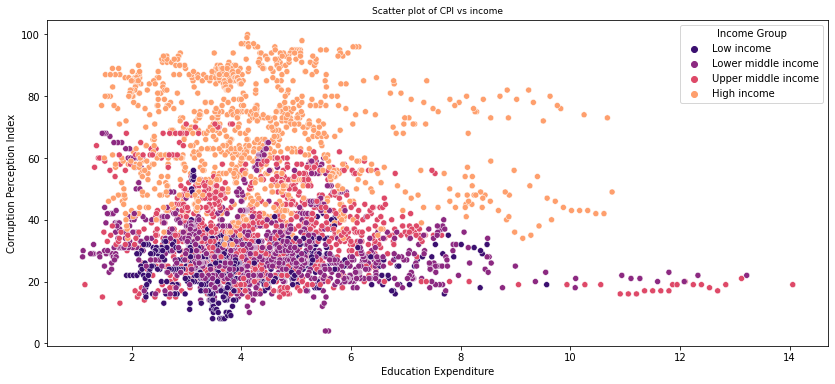

In [367]:
plt.figure(figsize=(14,6))
sns.scatterplot(x='Education Expenditure',y='Score',data=corruption_correlations_cleaned,palette='magma',hue='Income Group',hue_order=['Low income','Lower middle income','Upper middle income','High income'])
plt.ylabel('Corruption Perception Index')
plt.title('Scatter plot of CPI vs income')

Text(0.5, 1.0, 'Scatter plot of CPI vs Political Stability')

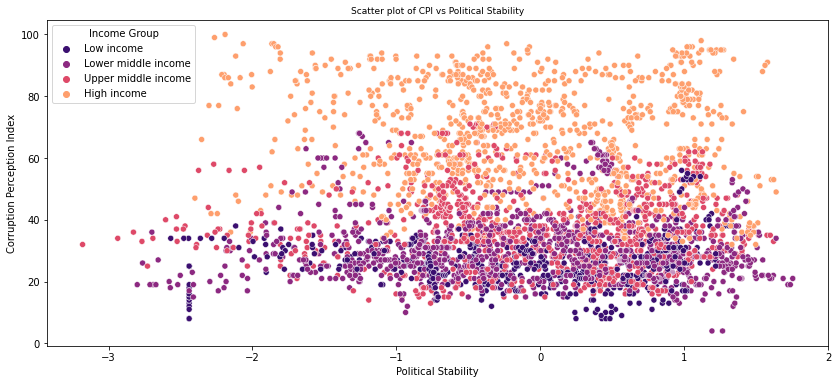

In [368]:
plt.figure(figsize=(14,6))
sns.scatterplot(x='Political Stability',y='Score',data=corruption_correlations_cleaned,palette='magma',hue='Income Group',hue_order=['Low income','Lower middle income','Upper middle income','High income'])
plt.ylabel('Corruption Perception Index')
plt.title('Scatter plot of CPI vs Political Stability')


Text(0.5, 1.0, 'Scatter plot of CPI vs Ease of doing business score')

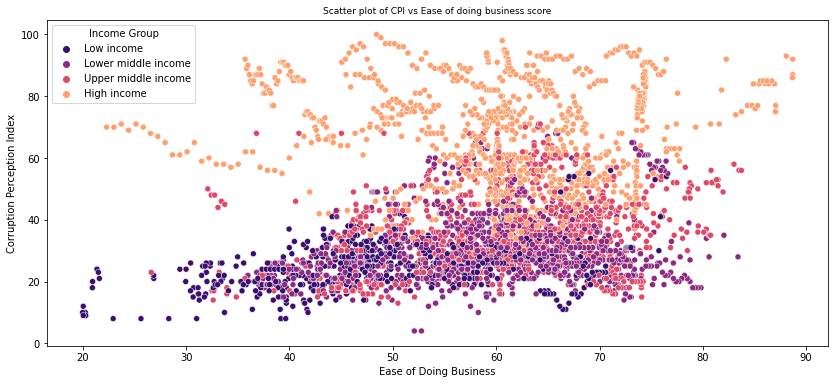

In [369]:
plt.figure(figsize=(14,6))
sns.scatterplot(x='Ease of Doing Business',y='Score',data=corruption_correlations_cleaned,palette='magma',hue='Income Group',hue_order=['Low income','Lower middle income','Upper middle income','High income'])
plt.ylabel('Corruption Perception Index')
plt.title('Scatter plot of CPI vs Ease of doing business score')

In [370]:
## all correlations

# sns.set(style="ticks", color_codes=True)
# sns.pairplot(corruption_correlations_cleaned)
# plt.show()

# World map

## Change of CPI Score between 2000 to 2020

In [371]:
d_2000 = corruption_correlations_cleaned[corruption_correlations_cleaned['Year']=='2000']
d_2020 = corruption_correlations_cleaned[corruption_correlations_cleaned['Year']=='2020']
merged_df = pd.merge(d_2000[['ISO','Score']], d_2020[['ISO','Score']],  on=['ISO'], how='outer')

merged_df['Change'] = np.round(((merged_df['Score_y'] - merged_df['Score_x'])/merged_df['Score_y']) *100, 0)
merged_df.head(200)

,ISO,Score_x,Score_y,Change
0,AFG,25.0,19.0,-32.0
1,AGO,17.0,27.0,37.0
2,ALB,25.0,36.0,31.0
3,ARE,52.0,71.0,27.0
4,ARG,35.0,42.0,17.0
...,...,...,...,...
172,VUT,31.0,43.0,28.0
173,YEM,26.0,15.0,-73.0
174,ZAF,50.0,44.0,-14.0
175,ZMB,34.0,33.0,-3.0


In [372]:
###Set the data for the world map
data=dict(type='choropleth',
         locations=merged_df['ISO'],         
         z=merged_df['Change'],
         #text=merged_df['Country'],
         colorbar={'title':'Change of CPI Score (in %) '},colorscale = 'RdYlBu'
)


In [373]:
###Define the layout of the world map
layout=dict(title='Change of CPI Score between 2000 to 2020',
           geo=dict(showframe=False,
                   projection={'type':'natural earth'}))

In [374]:
###Create the map
choromap=go.Figure(data=[data],layout=layout)

In [375]:
###Plot of the world map
###CPI Score of the different countries for the year 2020
iplot(choromap)

### How did the corruption rates change over the last 20 years?

World map plot shows that countries with decreasing CPI Score are becoming more corrupt and vice-versa.

Top 5 countries where corruption increased:

|Country|%Change|
|--|--:|
|Syria|	-143|
|Venezuela|	-80|
|Somalia|	-75|
|Yemen|	-73|
|Bahrain|	-45|

Top 5 countries where corruption decreased:

|Country|%Change|
|--|--:|
|Bangladesh|85|
|Georgia|57|
|Ukraine|55|
|India|54|
|Nigeria|52|


## CPI Score 2020

In [376]:
d_2020 = corruption_correlations_cleaned[corruption_correlations_cleaned['Year']=='2020']

###Set the data for the world map
data=dict(type='choropleth',
         locations=d_2020['ISO'],         
         z=d_2020['Score'],
         text=d_2020['Country'],
         colorbar={'title':'CPI Score 2020'},colorscale = 'RdYlBu')


###Define the layout of the world map
layout=dict(title='CPI Score 2020',
           geo=dict(showframe=False,
                   projection={'type':'natural earth'}))

###Create the map
choromap=go.Figure(data=[data],layout=layout)

###Plot of the world map
###CPI Score of the different countries for the year 2020
iplot(choromap)

### Comparison of corruption scores for 2020.

World map plot shows the corruption scores for 2020.

Top 5 countries with the highest corruption:

|Country| CPI Score|
|--|--:|
|Somalia | 12|
|Syria |14|
|Venezuela| 15|
|Yemen| 15|
|Equatorial New Guinnea| 16|

Top 5 countries with lowest corruption:

|Country| CPI Score|
|--|--:|
|Denmark |88|
|New Zealand |88|
|Switzerland |85|
|Finland |85|
|Singapore |85|





# Prepare dataset for training

In [377]:
categorical_columns = ['Income Group','Region']
df_encode = pd.get_dummies(data = corruption_correlations_cleaned, prefix = 'OHE', prefix_sep = '_', columns = categorical_columns,drop_first=True,dtype='int8')
df_encode = df_encode.drop(columns=['ISO','Year','Country'])

In [378]:
print('Columns in original data frame:\n',corruption_correlations_cleaned.columns.values)
print('\nNumber of rows and columns in the dataset:',corruption_correlations_cleaned.shape)
print('\nColumns in data frame after encoding dummy variable:\n',df_encode.columns.values)
print('\nNumber of rows and columns in the dataset:',df_encode.shape)

Columns in original data frame:
 ['ISO' 'Year' 'Score' 'Country' 'Region' 'Income Group' 'GDP'
 'Gender Equality' 'Education Expenditure' 'Political Stability'
 'Regulatory Quality' 'Unemployment' 'Population' 'Ease of Doing Business'
 'Renewable Energy Consumption' 'Population Growth' 'Population Density'
 'Military Expenditure' 'Land Area' 'Alcohol Consumption'
 'Life Expectancy' 'Inflation' 'Infant Mortality' 'Suicide rate']

Number of rows and columns in the dataset: (3717, 24)

Columns in data frame after encoding dummy variable:
 ['Score' 'GDP' 'Gender Equality' 'Education Expenditure'
 'Political Stability' 'Regulatory Quality' 'Unemployment' 'Population'
 'Ease of Doing Business' 'Renewable Energy Consumption'
 'Population Growth' 'Population Density' 'Military Expenditure'
 'Land Area' 'Alcohol Consumption' 'Life Expectancy' 'Inflation'
 'Infant Mortality' 'Suicide rate' 'OHE_Low income'
 'OHE_Lower middle income' 'OHE_Upper middle income'
 'OHE_Europe & Central Asia' 'OHE_Lat

In [379]:
y_bc,lam, ci= boxcox(df_encode['Score'],alpha=0.05)
ci,lam

((-0.10773992736088028, 0.010487866886189244), -0.04893670474260889)

In [380]:
df_encode['Score'] = np.log(df_encode['Score'])

In [381]:
X = df_encode.drop('Score',axis=1) # Independet variable
y = df_encode['Score'] # dependent variable

## Split the dataset into train and test

In [382]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

## Standarize the dataset

In [383]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [384]:
# Step 1: add x0 =1 to dataset
X_train_0 = np.c_[np.ones((X_train.shape[0],1)),X_train]
X_test_0 = np.c_[np.ones((X_test.shape[0],1)),X_test]

# Step2: build model
theta = np.matmul(np.linalg.inv( np.matmul(X_train_0.T,X_train_0) ), np.matmul(X_train_0.T,y_train)) 

# The parameters for linear regression model
parameter = ['theta_'+str(i) for i in range(X_train_0.shape[1])]
columns = ['intersect:x_0=1'] + list(X.columns.values)
parameter_df = pd.DataFrame({'Parameter':parameter,'Columns':columns,'theta':theta})

# Predictions

## Linear Regression

In [385]:
# Scikit Learn module

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Parameter
sk_theta = [lin_reg.intercept_]+list(lin_reg.coef_)
parameter_df = parameter_df.join(pd.Series(sk_theta, name='Sklearn_theta'))
parameter_df



,Parameter,Columns,theta,Sklearn_theta
0,theta_0,intersect:x_0=1,3.617098,3.617098
1,theta_1,GDP,-0.021309,-0.021309
2,theta_2,Gender Equality,-0.000802,-0.000802
3,theta_3,Education Expenditure,-0.043535,-0.043535
4,theta_4,Political Stability,-0.024159,-0.024159
5,theta_5,Regulatory Quality,0.082326,0.082326
6,theta_6,Unemployment,-0.003868,-0.003868
7,theta_7,Population,-0.003590,-0.003590
8,theta_8,Ease of Doing Business,0.066034,0.066034
9,theta_9,Renewable Energy Consumption,0.015800,0.015800


In [386]:
# Normal equation
y_pred_norm =  np.matmul(X_test_0,theta)

#Evaluvation: MSE
J_mse = np.sum((y_pred_norm - y_test)**2)/ X_test_0.shape[0]

# R_square 
sse = np.sum((y_pred_norm - y_test)**2)
sst = np.sum((y_test - y_test.mean())**2)
R_square = 1 - (sse/sst)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse)
print('R square obtain for normal equation method is :',R_square)

The Mean Square Error(MSE) or J(theta) is:  0.08577646017912559
R square obtain for normal equation method is : 0.6584684407982222


In [387]:
# sklearn regression module
y_pred_sk = lin_reg.predict(X_test)

#Evaluvation: MSE
J_mse_sk = mean_squared_error(y_pred_sk, y_test)

# R_square
R_square_sk = lin_reg.score(X_test,y_test)
print('The Mean Square Error(MSE) or J(theta) is: ',J_mse_sk)
print('R square obtain for scikit learn library is :',R_square_sk)

The Mean Square Error(MSE) or J(theta) is:  0.08577646017912569
R square obtain for scikit learn library is : 0.6584684407982219


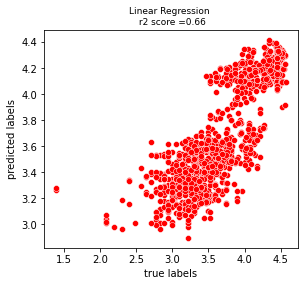

In [388]:
# Check for Linearity
f = plt.figure(figsize=(10,4))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred_sk,ax=ax,color='r')
ax.set_title('Linear Regression \n r2 score ='+str(format(R_square, '.2f')))
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred_sk),ax=ax,color='b')
ax.axvline((y_test - y_pred_sk).mean(),color='k',linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual eror');

## Decision Tree

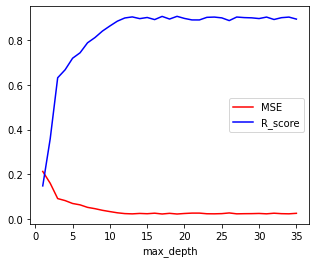

In [389]:
m = np.arange(1,36)

M_score = []
R_score = []
for i in m:
  # Create Decision Tree object
  clf = DecisionTreeRegressor(max_depth = i)

  # Train Decision Tree 
  model = clf.fit(X_train,y_train)

  #Predict the response for test dataset
  y_pred = model.predict(X_test)

  M_score.append(mean_squared_error(y_pred, y_test))
  R_score.append(model.score(X_test,y_test))


# plot mse and r2 scores vs max_depths

plt.figure(figsize=(5,4))
plt.plot(m, M_score, color = 'red',label = 'MSE')
plt.plot(m, R_score, color = 'blue',label = 'R_score')
plt.xlabel('max_depth')
plt.legend(loc = 'best')
plt.show()

Mean Square Error(MSE):  0.026750185547191732
R_score : 0.8934902121189121


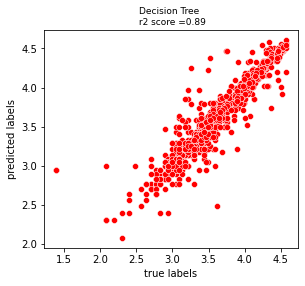

In [390]:
# Create Decision Tree classifer object
decision_tree = DecisionTreeRegressor(max_depth = 30)

# Train Decision Tree Classifer
decision_tree = decision_tree.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = decision_tree.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

# R_square
R_square = decision_tree.score(X_test,y_test)
print('Mean Square Error(MSE): ',J_mse)
print('R_score :',R_square)

f = plt.figure(figsize=(10,4))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('Decision Tree \n r2 score ='+str(format(R_square, '.2f')))
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

## kNN - k-Nearest-Neighboor


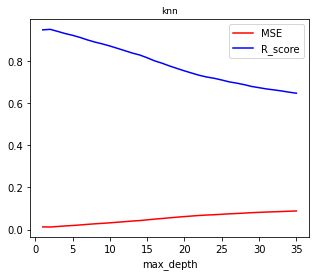

In [391]:
k = np.arange(1,30)

M_score = []
R_score = []
for i in m:
  # Create knn object
  clf = KNeighborsRegressor(n_neighbors = i)

  # Train knn
  model = clf.fit(X_train,y_train)

  #Predict the response for test dataset
  y_pred = model.predict(X_test)

  M_score.append(mean_squared_error(y_pred, y_test))
  R_score.append(model.score(X_test,y_test))


# plot mse and r2 scores vs max_depths

plt.figure(figsize=(5,4))
plt.plot(m, M_score, color = 'red',label = 'MSE')
plt.plot(m, R_score, color = 'blue',label = 'R_score')
plt.xlabel('max_depth')
plt.legend(loc = 'best')
plt.title('knn')
plt.show()

Mean Square Error(MSE):  0.019845872921896424
R_score : 0.9209807456663371


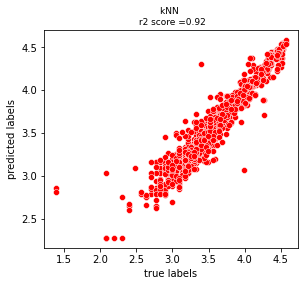

In [392]:
# Create knn object
knn = KNeighborsRegressor(n_neighbors = 5)

# Train knn
knn = knn.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

# R_square
R_square = knn.score(X_test,y_test)
print('Mean Square Error(MSE): ',J_mse)
print('R_score :',R_square)

f = plt.figure(figsize=(10,4))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('kNN \n r2 score ='+str(format(R_square, '.2f')))
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

# Feature selection
PCA method was used for selecting features. We observed that feature selection procedure actually worsened the model performance. It could be because none of the features had strong correlation with the the prediction variable. Hence our feature selection method was not applied.

(3717, 15)
Mean Square Error(MSE):  0.17529990986310093
R_score : 0.30201769321735283


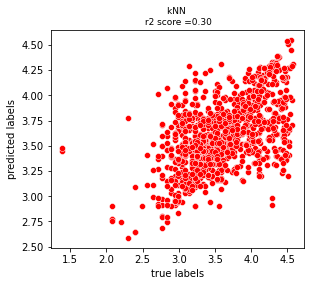

In [393]:
# Feature Selection with Univariate Statistical Tests

X = df_encode.drop('Score',axis=1) # Independet variable
y = df_encode['Score'] # dependent variable

sc = StandardScaler()
Xt1 = sc.fit_transform(X)

# feature extraction
pca = decomposition.PCA(n_components=15)
pca.fit(X)
X = pca.transform(X)
print(X.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3,random_state=23)

# Create knn object
knn = KNeighborsRegressor(n_neighbors = 5)

# Train knn
knn = knn.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = knn.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

# R_square
R_square = knn.score(X_test,y_test)
print('Mean Square Error(MSE): ',J_mse)
print('R_score :',R_square)

f = plt.figure(figsize=(10,4))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('kNN \n r2 score ='+str(format(R_square, '.2f')))
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()

Mean Square Error(MSE):  0.2016727740875082
R_score : 0.197010265534174


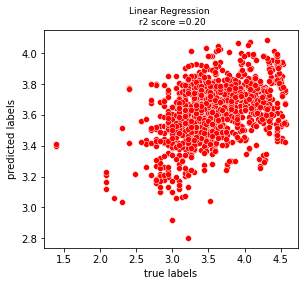

In [394]:
lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train) # Note: x_0 =1 is no need to add, sklearn will take care of it.

#Predict the response for test dataset
y_pred = lin_reg.predict(X_test)

J_mse = mean_squared_error(y_pred, y_test)

# R_square
R_square = lin_reg.score(X_test,y_test)
print('Mean Square Error(MSE): ',J_mse)
print('R_score :',R_square)

f = plt.figure(figsize=(10,4))
ax = f.add_subplot(121)
sns.scatterplot(y_test,y_pred,ax=ax,color='r')
ax.set_title('Linear Regression \n r2 score ='+str(format(R_square, '.2f')))
plt.xlabel('true labels')
plt.ylabel('predicted labels')
plt.show()